In [38]:
import os
os.makedirs("salidas", exist_ok=True)
os.makedirs("matplotlib-cache", exist_ok=True)
os.environ['MPLCONFIGDIR'] = 'matplotlib-cache'
import requests 
import json 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap  
from matplotlib.colors import LinearSegmentedColormap 
from pygbif import species, name_backbone 
import re 
import geopandas as gpd 
import seaborn as sns 
import colorcet as cc 
import random  
from shapely.geometry import Point  
import shutil  
import glob  
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier 
from xgboost import XGBClassifier  
from lightgbm import LGBMClassifier  
from sklearn import model_selection  
from pyimpute import load_training_vector
from pyimpute import load_targets  
from pyimpute import impute  

In [39]:
pd.set_option('display.width', 1000)  
pd.set_option('display.max_columns', None)  
plt.set_loglevel('WARNING') 

In [40]:
salida_dic = {'orden':'order', 'familia':'family', 'género':'genus', 'genero':'genus', 'especie':'species'}
consulta = 'Asclepias nivea'
salida_por = 'especie'

In [41]:
clave = name_backbone(consulta) 
pd.set_option('display.max_columns', None)
pd.DataFrame([clave]) 

usageKey      scientificName    canonicalName     rank    status  confidence matchType  kingdom        phylum        order       family      genus          species  kingdomKey  phylumKey  classKey  orderKey  familyKey  genusKey  speciesKey          class
0   3170240  Asclepias nivea L.  Asclepias nivea  SPECIES  ACCEPTED          97     EXACT  Plantae  Tracheophyta  Gentianales  Apocynaceae  Asclepias  Asclepias nivea           6    7707728       220       412       6701   3170229     3170240  Magnoliopsida

In [42]:
def get_GBIF_response(base_url, offset, params, df):
    """Performs an API call to the base URL with additional parameters listed in 'params'. Concatenates response to
    a Pandas DataFrame, 'df'"""
    
    query = base_url+'&'+f'offset={offset}'
    for each in params:
        query = query+'&'+each
   
    response = requests.get(query)
    
    if response.status_code != 200:
        print(f"API call failed at offset {offset} with a status code of {response.status_code}.")
    else:
        result = response.json()
        df_concat = pd.concat([df, pd.DataFrame.from_dict(result['results'])], axis = 0, ignore_index = True, sort = True)
        endOfRecords = result['endOfRecords']
        for column in df_concat.columns:
            if df_concat[column].dtype == 'object':
                df_concat[column] = df_concat[column].astype('string')
        return df_concat, endOfRecords, response.status_code

In [43]:
codigo = clave['usageKey']
base_url = "https://api.gbif.org/v1/occurrence/search?"
clave_elegida = f'taxonKey={3170240}'
params = ['limit=300', clave_elegida, 'hasCoordinate=true', 'hasGeospatialIssue=false', 'country=DO']
print(params)

['limit=300', 'taxonKey=3170240', 'hasCoordinate=true', 'hasGeospatialIssue=false', 'country=DO']


In [44]:
%%time
df = pd.DataFrame()
endOfRecords = False
offset = 0
status = 200

while endOfRecords == False and status == 200:
    df, endOfRecords, status = get_GBIF_response(base_url, offset, params, df)
    offset = len(df) + 1

CPU times: user 62 ms, sys: 4.07 ms, total: 66.1 ms
Wall time: 1.82 s


In [45]:
print(f'Se encontraron {len(df.index)} registros para {consulta} en la base de datos de GBIF')

Se encontraron 141 registros para Asclepias nivea en la base de datos de GBIF


In [46]:
print(f'La categoría taxonómica de salida es {salida_por}, en concreto, la consulta fue hecha para {consulta}')

La categoría taxonómica de salida es especie, en concreto, la consulta fue hecha para Asclepias nivea


In [47]:
df = df[[salida_dic[salida_por], 'decimalLongitude', 'decimalLatitude']].dropna().drop_duplicates()
df

species  decimalLongitude  decimalLatitude
0    Asclepias nivea        -70.583134        19.122061
1    Asclepias nivea        -71.612091        18.112934
2    Asclepias nivea        -70.557747        19.550028
3    Asclepias nivea        -70.642200        19.123675
4    Asclepias nivea        -71.702760        18.307564
..               ...               ...              ...
132  Asclepias nivea        -71.696046        18.715303
133  Asclepias nivea        -71.610972        18.737751
136  Asclepias nivea        -70.732682        18.452150
137  Asclepias nivea        -70.738773        18.912805
140  Asclepias nivea        -69.983333        18.500000

[130 rows x 3 columns]

In [48]:
print(f'El número de registros útiles es {len(df.index)}')

El número de registros útiles es 130


In [49]:
prefijo_archivo = consulta.replace(" ", "-").lower()
df.to_csv(f'{prefijo_archivo}-desde-python.csv')

In [50]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.decimalLongitude, df.decimalLatitude, crs = 'epsg:4326'))
gdf.head()

species  decimalLongitude  decimalLatitude                    geometry
0  Asclepias nivea        -70.583134        19.122061  POINT (-70.58313 19.12206)
1  Asclepias nivea        -71.612091        18.112934  POINT (-71.61209 18.11293)
2  Asclepias nivea        -70.557747        19.550028  POINT (-70.55775 19.55003)
3  Asclepias nivea        -70.642200        19.123675   POINT (-70.6422 19.12368)
4  Asclepias nivea        -71.702760        18.307564  POINT (-71.70276 18.30756)

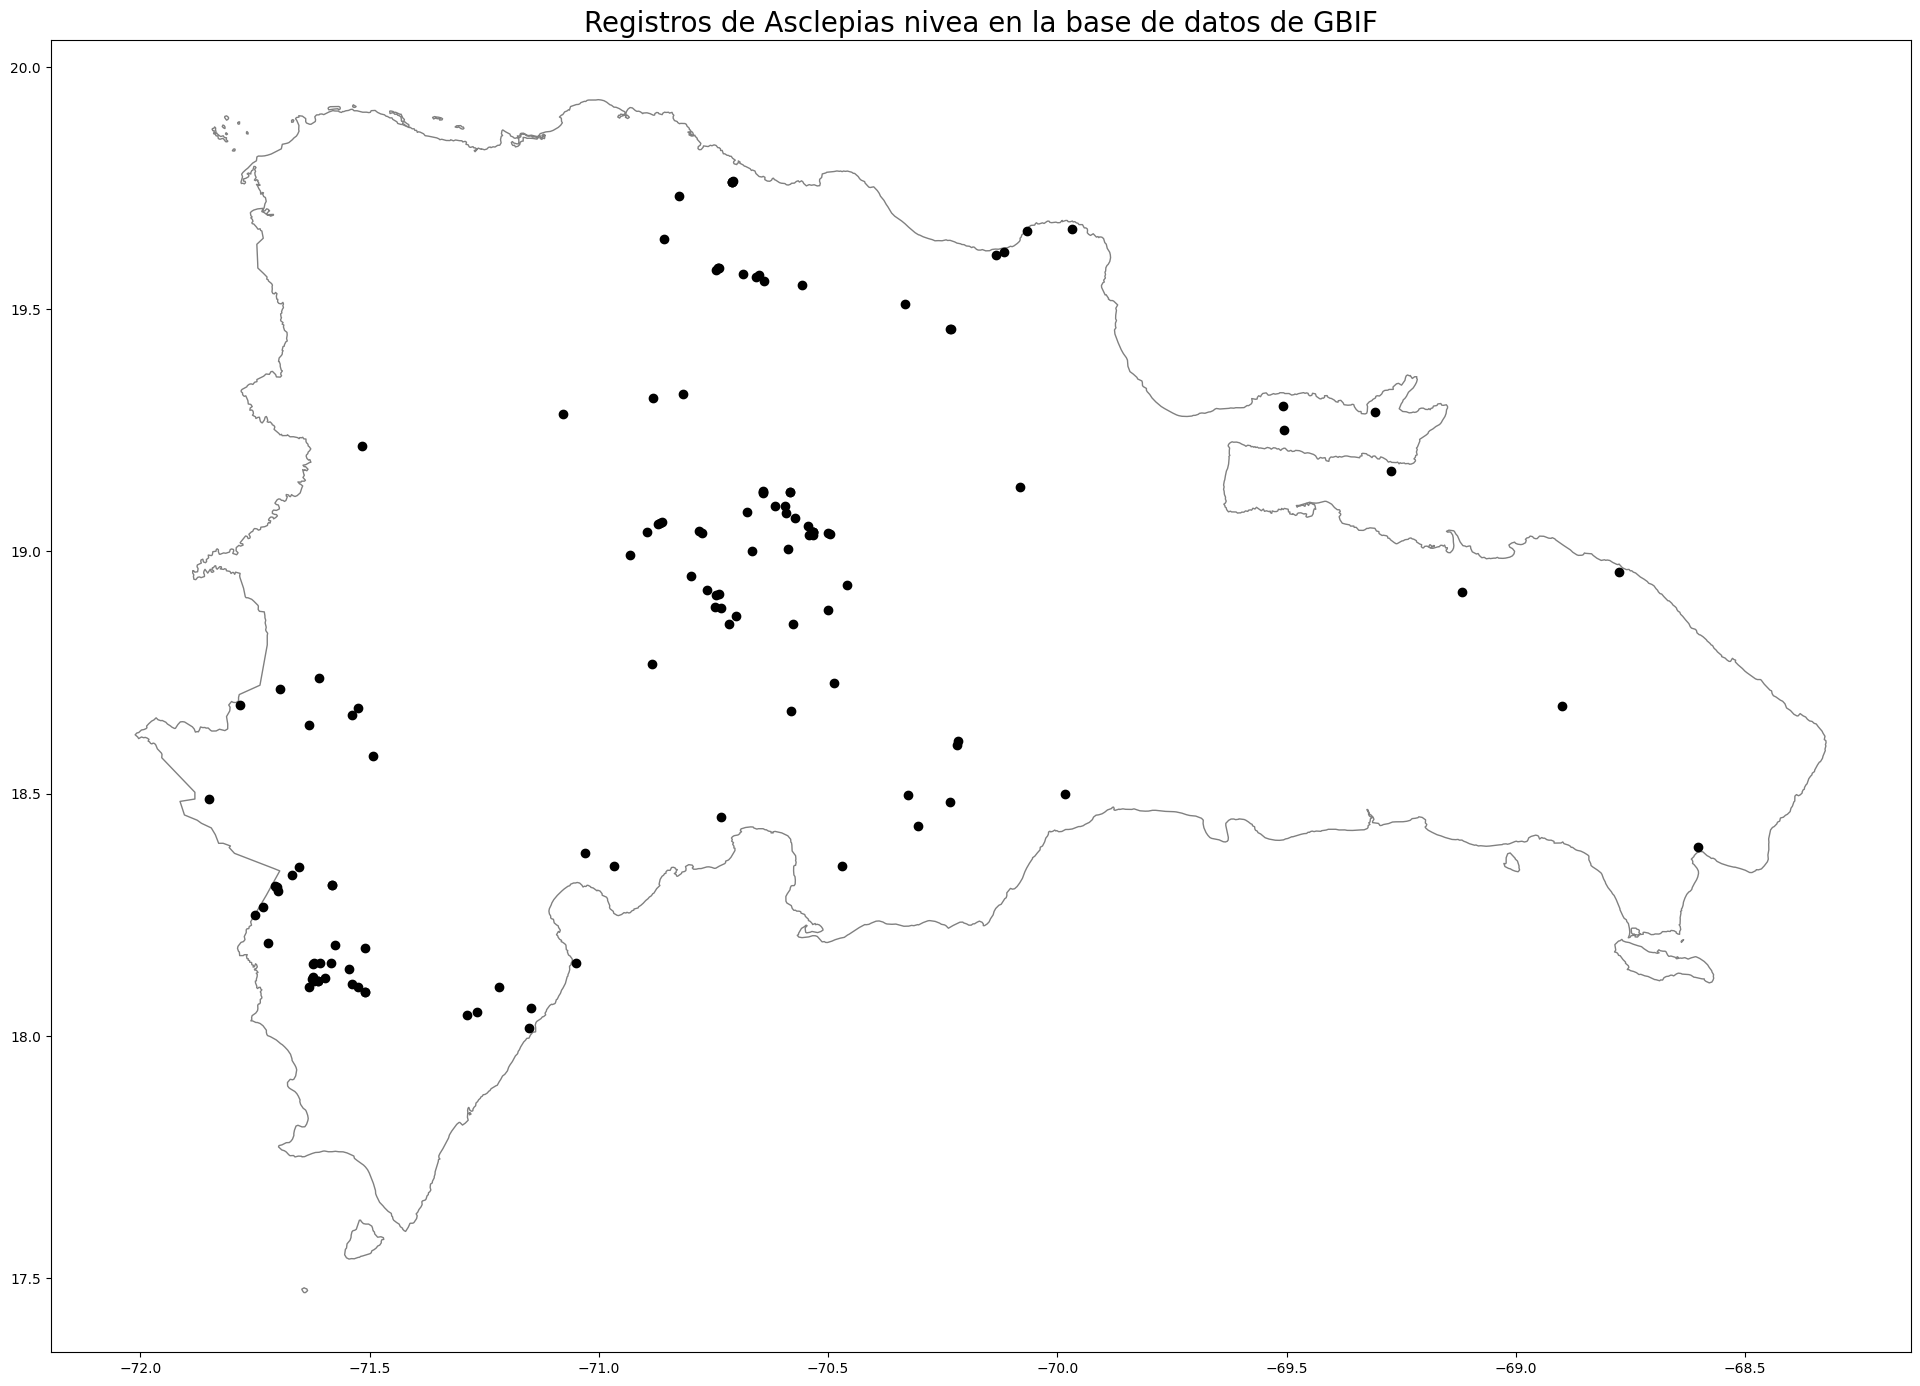

In [51]:

rd_url = 'https://github.com/biogeografia-202202/material-de-apoyo/raw/master/data/d002/rd.gpkg'
rd = gpd.read_file(rd_url, layer = 'pais')
rd_base = rd.plot(color='white', edgecolor='grey', figsize=(24,22))


col_salida_en_df = salida_dic[salida_por].lower()
species_name = gdf[col_salida_en_df].iloc[0]  # Nombre de la especie (si es constante en toda la columna)


gdf.plot(ax=rd_base, color="black", markersize=36)


plt.title(f"Registros de Asclepias nivea en la base de datos de GBIF", fontsize=20)

plt.show()

In [52]:
gdf.to_file(filename = f'{prefijo_archivo}-desde-python.gpkg', driver='GPKG')

INFO:Created 130 records


In [53]:
def columnas_azar(gdf_fuente): 
   
    return [gdf_fuente.columns[0]] + random.sample(list(gdf_fuente.columns[1:]), 3)

In [54]:
va7 = gpd.read_file('all_sources_all_variables_res_7.gpkg')
va7 = va7.filter(regex="^(?!.*base$)") 
columnas_seleccionadas_va7 = columnas_azar(va7)
va7[columnas_seleccionadas_va7].head()

hex_id  CGL Open forest, evergreen broad leaf  CGL Permanent water bodies  WCL bio08 Mean temperature of wettest quarter
0  874c88200ffffff                                    0.0                    0.000000                                     258.120401
1  874c88201ffffff                                    0.0                    0.000000                                     259.000000
2  874c88202ffffff                                    0.0                    0.465239                                     258.065163
3  874c88203ffffff                                    0.0                    0.000000                                     258.507937
4  874c88204ffffff                                    0.0                    0.000000                                     258.000000

<Axes: >

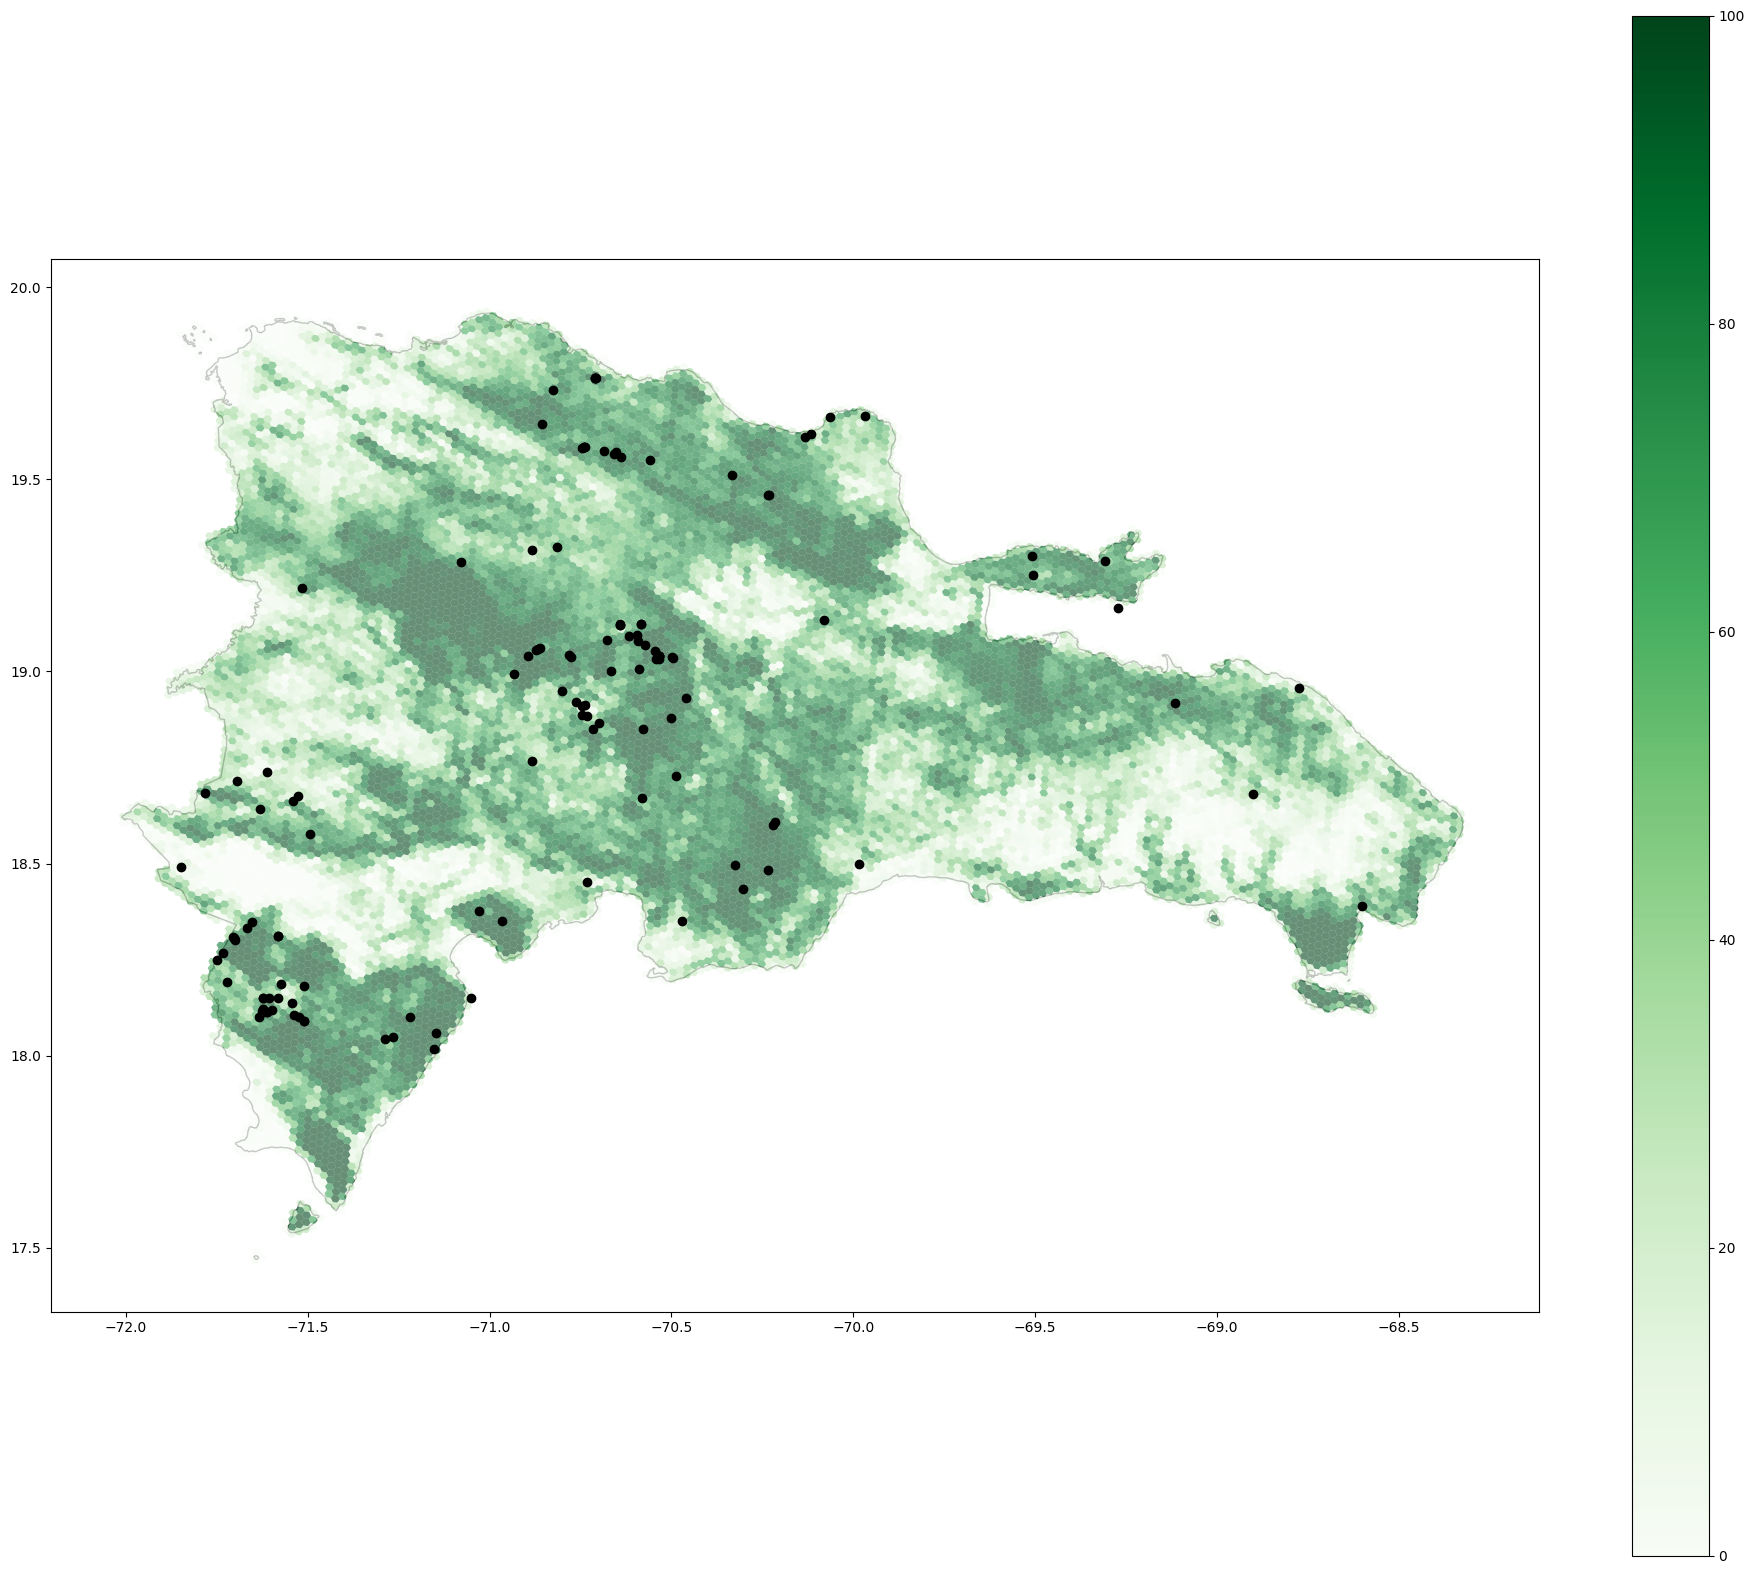

In [55]:
rd_base = rd.plot(color='white', edgecolor='grey', figsize=(24,20))
va7_base = va7.plot(column='ESA Trees', ax = rd_base, legend=True, cmap='Greens', alpha = 0.6)
gdf.plot(ax=va7_base, color="black", markersize=36)

In [56]:

presencia = gpd.sjoin(va7, gdf, how="inner", predicate="contains")

presencia = presencia.loc[~presencia.index.duplicated()]

presencia = presencia.to_crs(epsg=32619)
presencia['geometry'] = presencia['geometry'].centroid 
presencia = presencia.to_crs(gdf.crs)
print(f'Hay {len(presencia.index)} registros de presencia no redundantes dentro de hexágonos H3')

Hay 102 registros de presencia no redundantes dentro de hexágonos H3


In [57]:
presencia = presencia[['geometry']].copy()  
presencia['CLASS'] = 1 
presencia.sample(5) 

geometry  CLASS
814     POINT (-70.87996 19.3116)      1
6175   POINT (-70.58621 19.07367)      1
12990  POINT (-71.58009 18.17846)      1
6168   POINT (-70.49736 19.03159)      1
5241   POINT (-71.60104 18.15436)      1

In [58]:

hex_sin_presencia = va7[~va7.index.isin(presencia.index)]
columnas_seleccionadas_hex_sin_presencia = columnas_azar(hex_sin_presencia)

va7[columnas_seleccionadas_hex_sin_presencia].head()

hex_id  CGL Open forest, evergreen broad leaf  G90 Compound Topographic Index  CH-BIO bio11 mean daily mean air temperatures of the coldest quarter
0  874c88200ffffff                                    0.0                        0.936787                                        2980.963211                   
1  874c88201ffffff                                    0.0                        1.565307                                        2981.612364                   
2  874c88202ffffff                                    0.0                        1.130260                                        2980.192821                   
3  874c88203ffffff                                    0.0                        1.035087                                        2981.000000                   
4  874c88204ffffff                                    0.0                        1.425528                                        2980.835284

In [59]:

factor_pseudoausencias = 3 
num_pseudoausencias = min(len(hex_sin_presencia), factor_pseudoausencias * len(presencia))
pseudoausencia_hexagonos = hex_sin_presencia.sample(n=num_pseudoausencias, random_state=1)

In [60]:

pseudoausencia = pseudoausencia_hexagonos.copy()
pseudoausencia = pseudoausencia.to_crs(epsg=32619)
pseudoausencia['geometry'] = pseudoausencia['geometry'].centroid
pseudoausencia = pseudoausencia.to_crs(gdf.crs)
print(f'Hay {len(pseudoausencia.index)} puntos de pseudoausencias dentro de hexágonos H3')

Hay 306 puntos de pseudoausencias dentro de hexágonos H3


In [61]:

pseudoausencia = pseudoausencia[['geometry']]
pseudoausencia['CLASS'] = 0

In [62]:

pa = gpd.GeoDataFrame(pd.concat([presencia, pseudoausencia], ignore_index=True), crs=va7.crs)
pa.sample(5)

geometry  CLASS
351  POINT (-68.43796 18.40761)      0
57    POINT (-70.30951 18.4312)      1
63   POINT (-70.58463 19.09134)      1
297  POINT (-70.86716 19.45228)      0
159  POINT (-71.49892 19.05596)      0

In [63]:

print("Número de duplicados: ", pa.duplicated(subset='geometry', keep='first').sum())
print("Número de NA: ", pa['geometry'].isna().sum())
print("Sistema de coordenadas de referencia: {}".format(pa.crs))
print("{} observaciones (filas) con {} columnas".format(*pa.shape))

Número de duplicados:  0
Número de NA:  0
Sistema de coordenadas de referencia: EPSG:4326
408 observaciones (filas) con 2 columnas


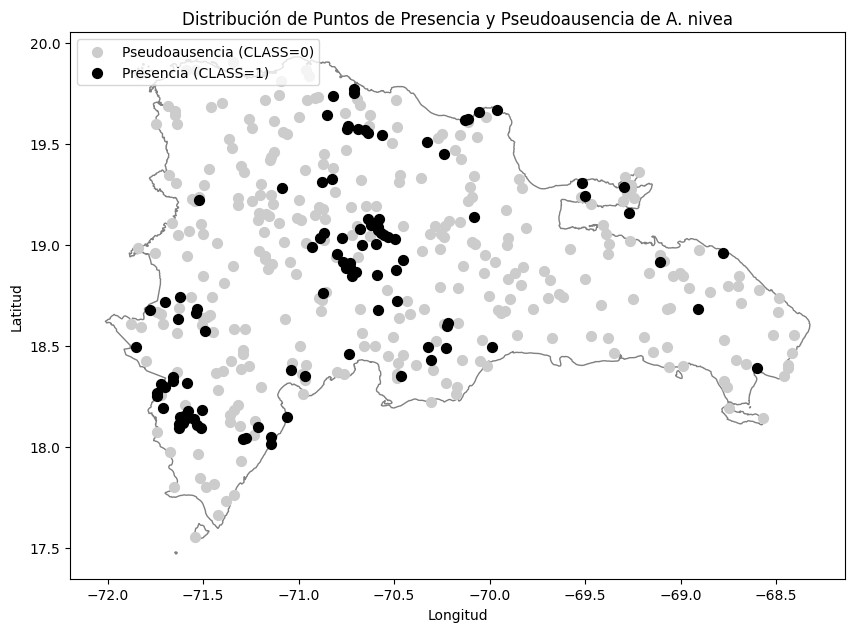

In [64]:

fig, ax = plt.subplots(figsize=(10, 10))


rd.plot(ax=ax, color='none', edgecolor='grey') 


pa[pa['CLASS'] == 0].plot(ax=ax, color="#CCCCCC", markersize=50, label="Pseudoausencia (CLASS=0)")
pa[pa['CLASS'] == 1].plot(ax=ax, color="black", markersize=50, label="Presencia (CLASS=1)")

# Configurar título y leyenda
ax.set_title("Distribución de Puntos de Presencia y Pseudoausencia de A. nivea")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.legend(loc="upper left")

plt.show()

In [65]:


pa_with_features = gpd.sjoin(pa, va7, how="left", predicate="intersects")
pa_with_features.sample(5)

geometry  CLASS  index_right           hex_id  ESA Trees  ESA Shrubland  ESA Grassland  ESA Cropland  ESA Built-up  ESA Barren / sparse vegetation  ESA Open water  ESA Herbaceous wetland  ESA Mangroves  CGL Closed forest, evergreen needle leaf  CGL Closed forest, evergreen broad leaf  CGL Closed forest, deciduous broad leaf  CGL Closed forest, mixed  CGL Closed forest, not matching any of the other definitions  CGL Open forest, evergreen needle leaf  CGL Open forest, evergreen broad leaf  CGL Open forest, deciduous broad leaf  CGL Open forest, mixed  CGL Open forest, not matching any of the other definitions  CGL Shrubs  CGL Oceans, seas  CGL Herbaceous vegetation  CGL Cultivated and managed vegetation / agriculture  CGL Urban / built up  CGL Bare / sparse vegetation  CGL Permanent water bodies  CGL Herbaceous wetland  GSL Peak/ridge (warm)  GSL Peak/ridge  GSL Mountain/divide  GSL Cliff  GSL Upper slope (warm)  GSL Upper slope  GSL Upper slope (cool)  \
178  POINT (-71.68225 19.68651)      0          135  874c882e2ffffff  10.247893       1.084343      15.217688      2.855215      0.373522                        9.328024        0.938476               17.972159       41.98268                                       0.0                                11.678586                                      0.0                  0.000000                                           3.951168                                                0.0                               2.069877                                    0.0                     0.0                                          16.615497             5.188357               0.0                   5.691249                                                0.0                0.474650                           0.0                         0.0               54.330615               0.000000             0.0                  0.0        0.0               10.742305              0.0                     0.0   
384  POINT (-70.64972 19.19202)      0          854  874c89348ffffff  56.344206       0.031887      43.579266      0.000000      0.044642                        0.000000        0.000000                0.000000        0.00000                                       0.0                                 6.065154                                      0.0                  0.000000                                           0.933382                                                0.0                               5.624085                                    0.0                     0.0                                          73.315337             1.619693               0.0                  12.442350                                                0.0                0.000000                           0.0                         0.0                0.000000               0.634913             0.0                  0.0        0.0               44.158250              0.0                     0.0   
152  POINT (-69.86597 18.85973)      0         7099  874cd4aadffffff  89.474192       0.000000      10.525808      0.000000      0.000000                        0.000000        0.000000                0.000000        0.00000                                       0.0                                26.342746                                      0.0                  0.000000                                           8.101994                                                0.0                              11.370930                                    0.0                     0.0                                          50.837234             0.000000               0.0                   3.347096                                                0.0                0.000000                           0.0                         0.0                0.000000               8.228396             0.0                  0.0        0.0               47.296553              0.0                     0.0   
328   POINT (-70.4916 19.71681)      0        11052  87

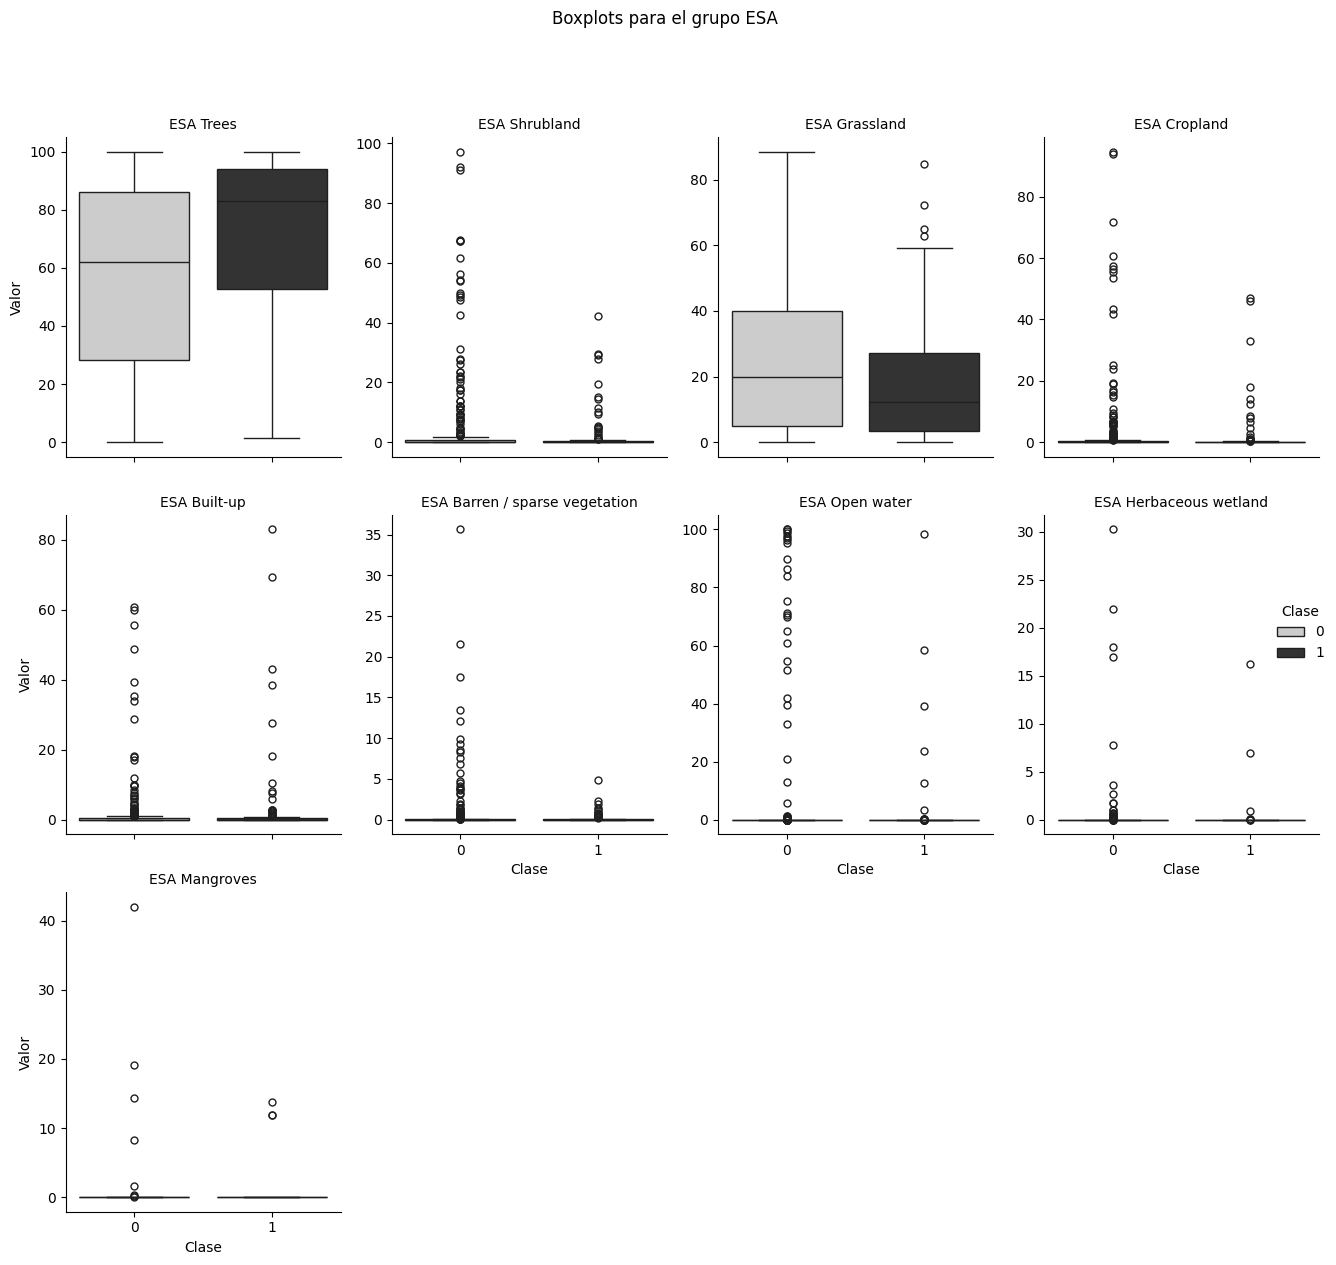

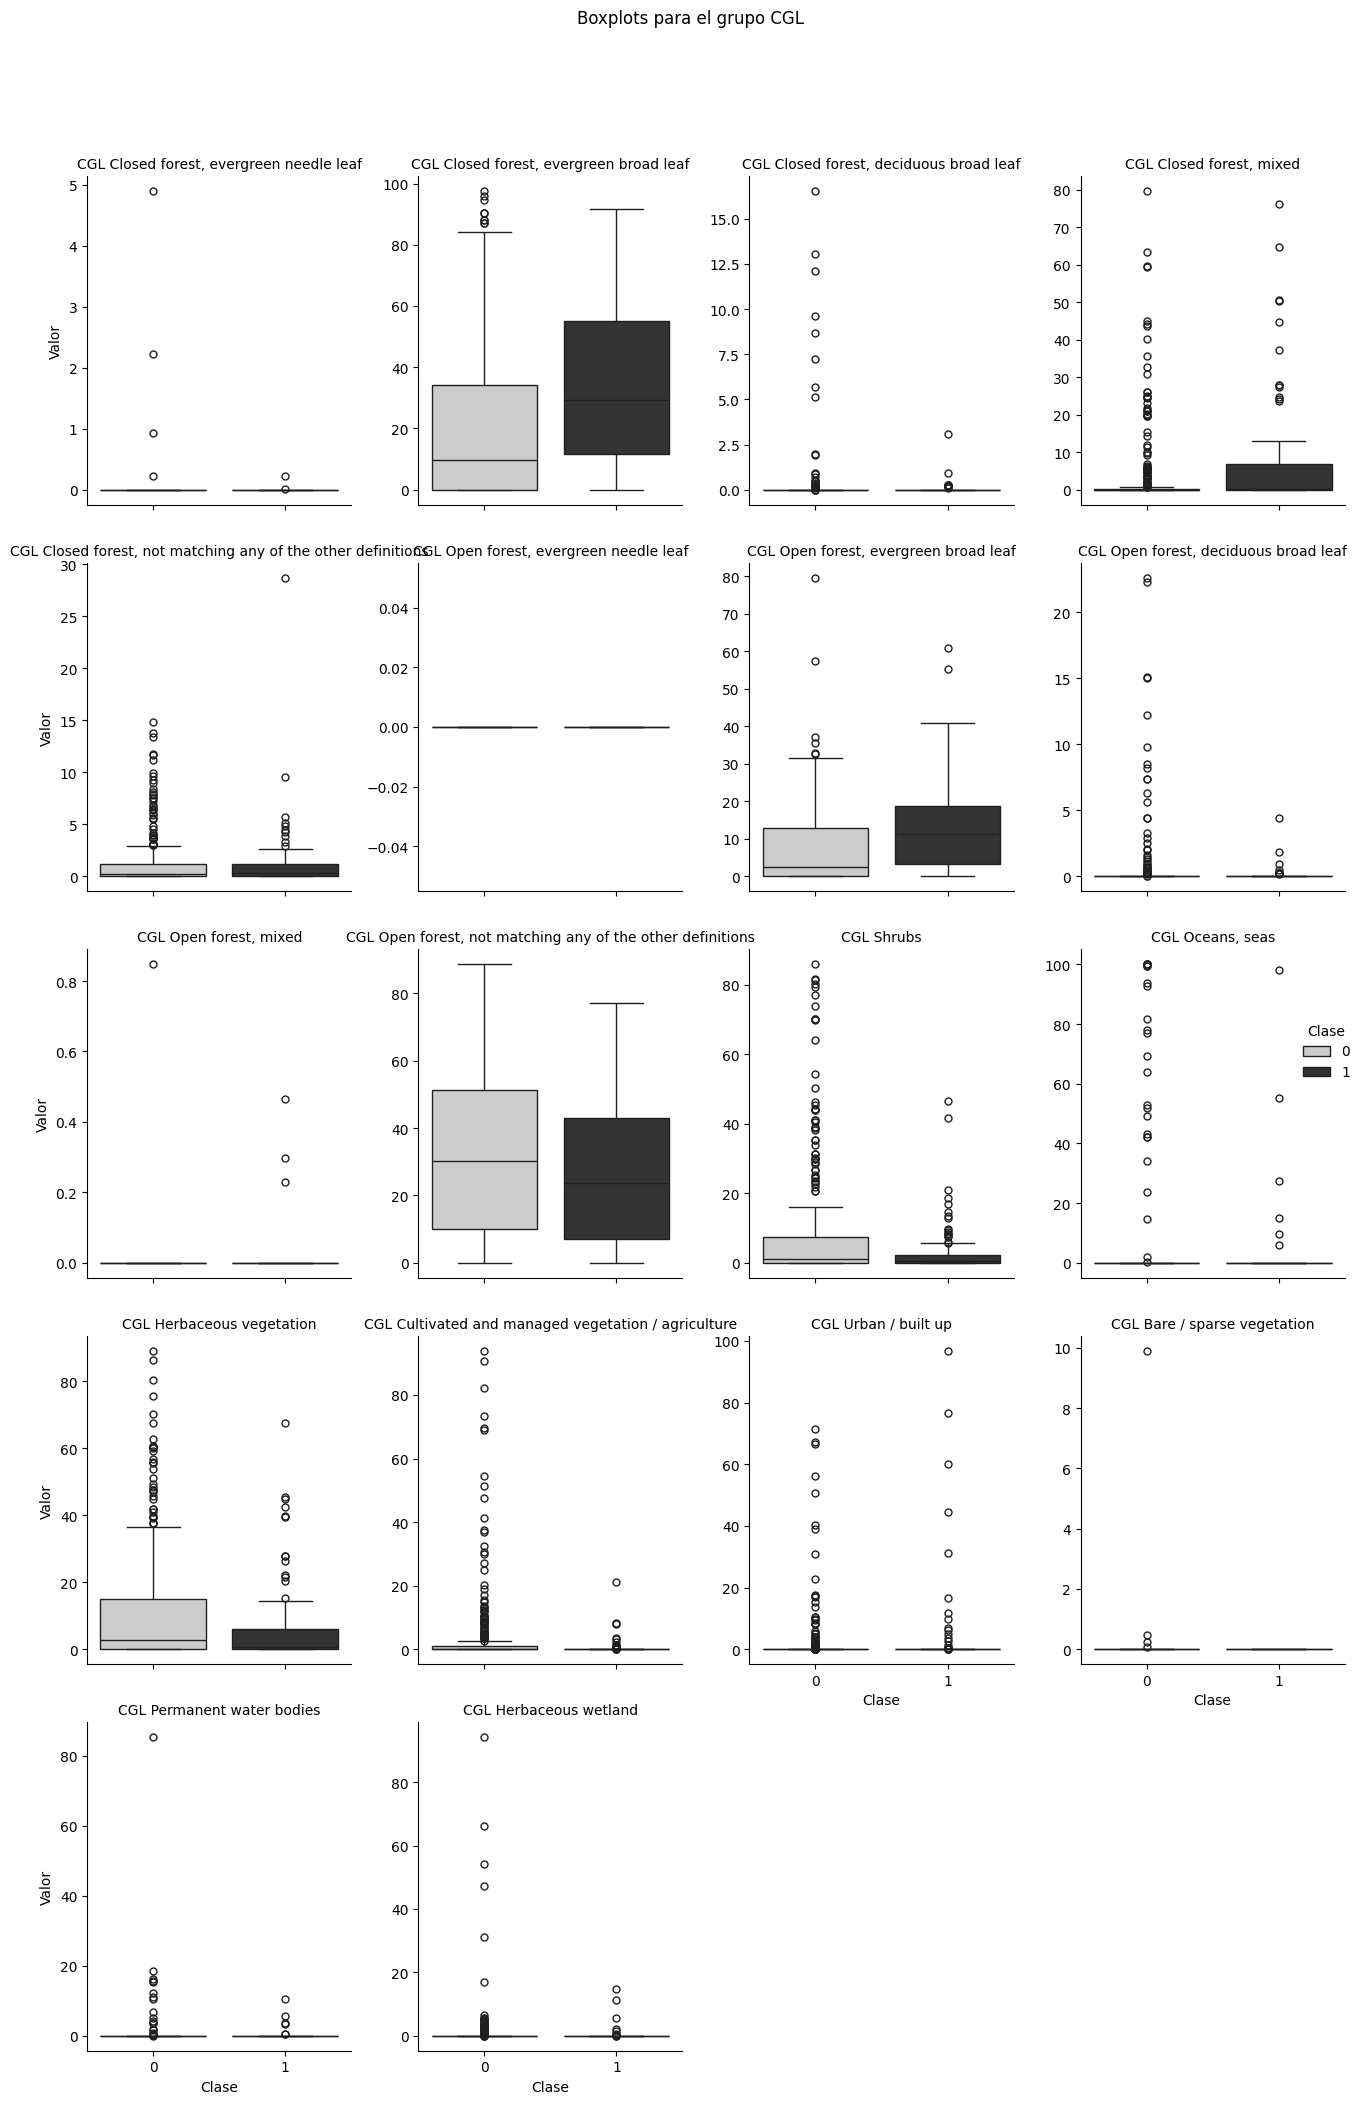

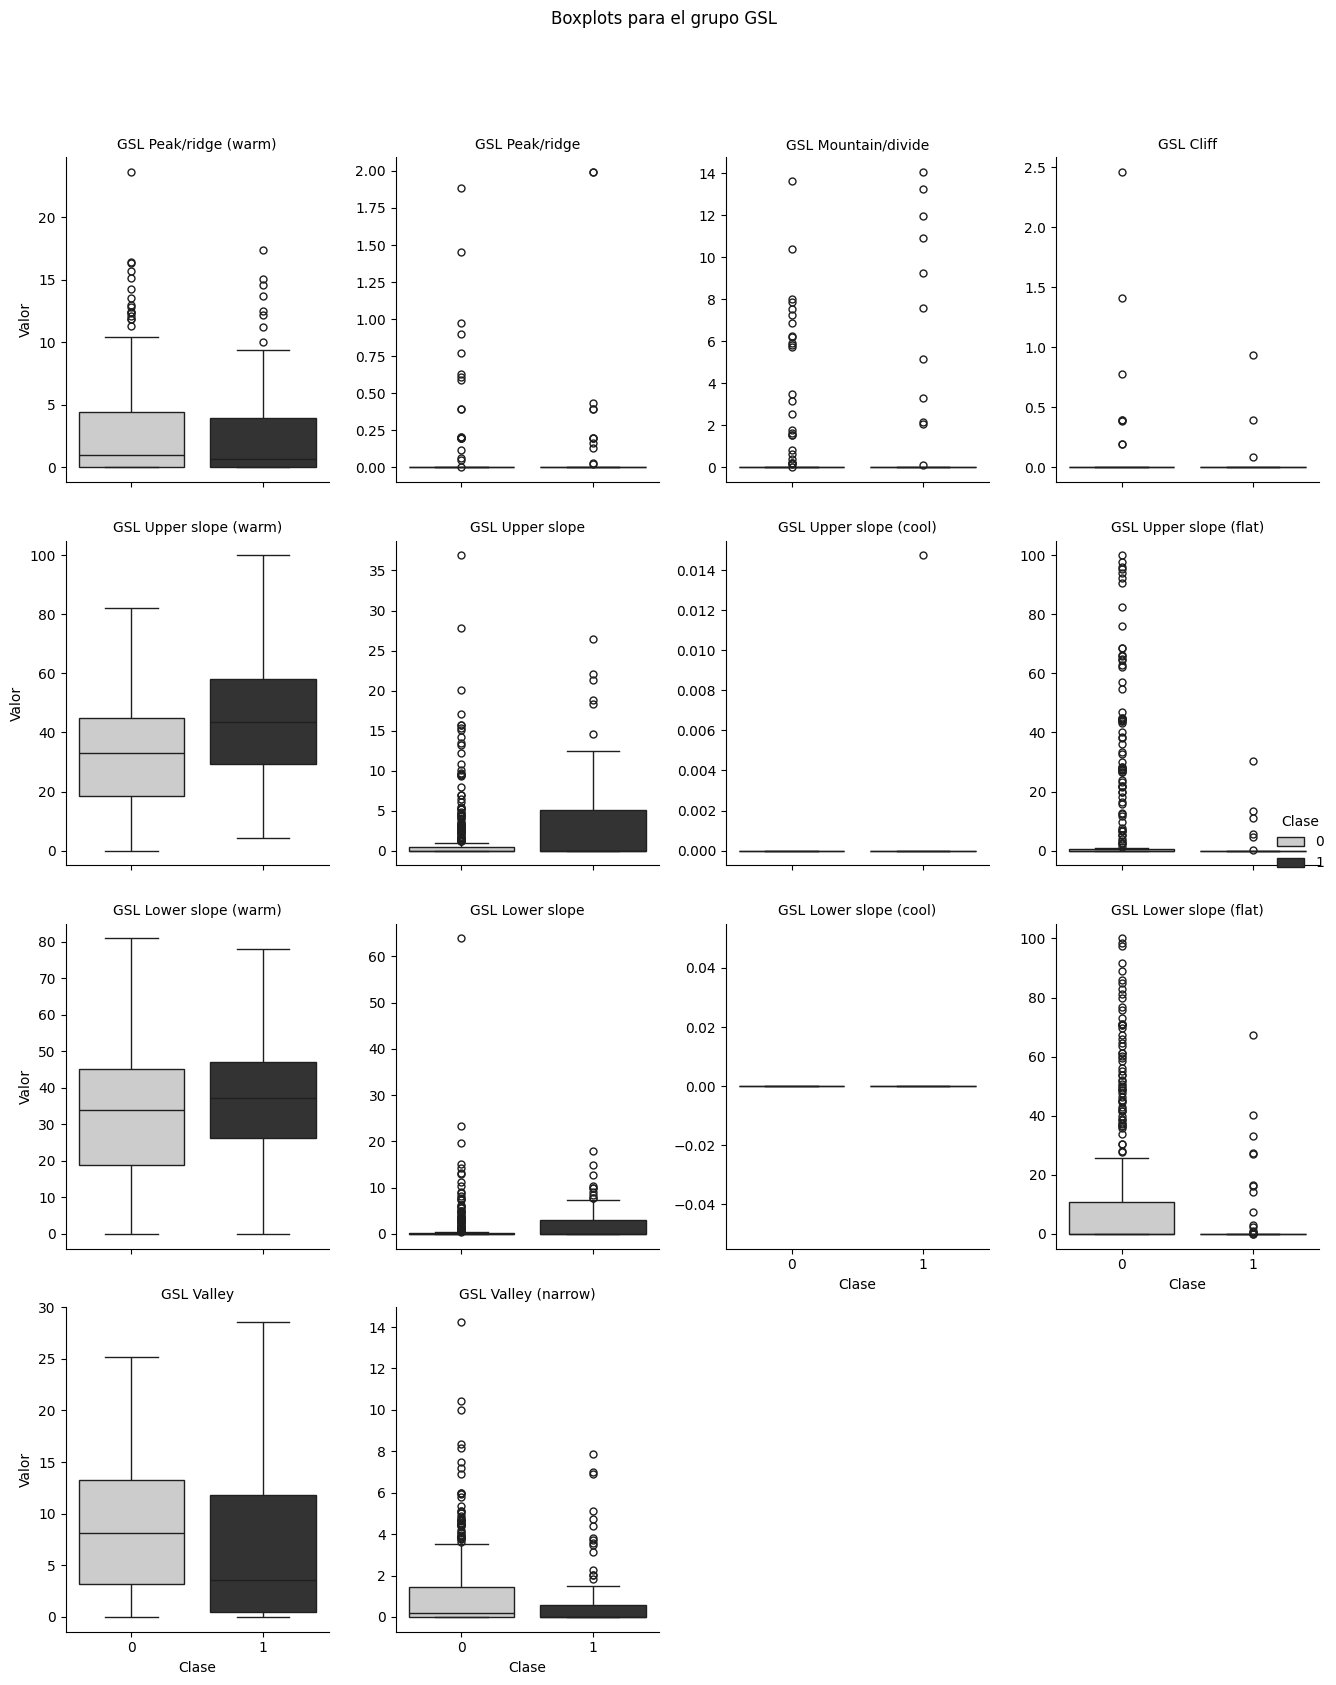

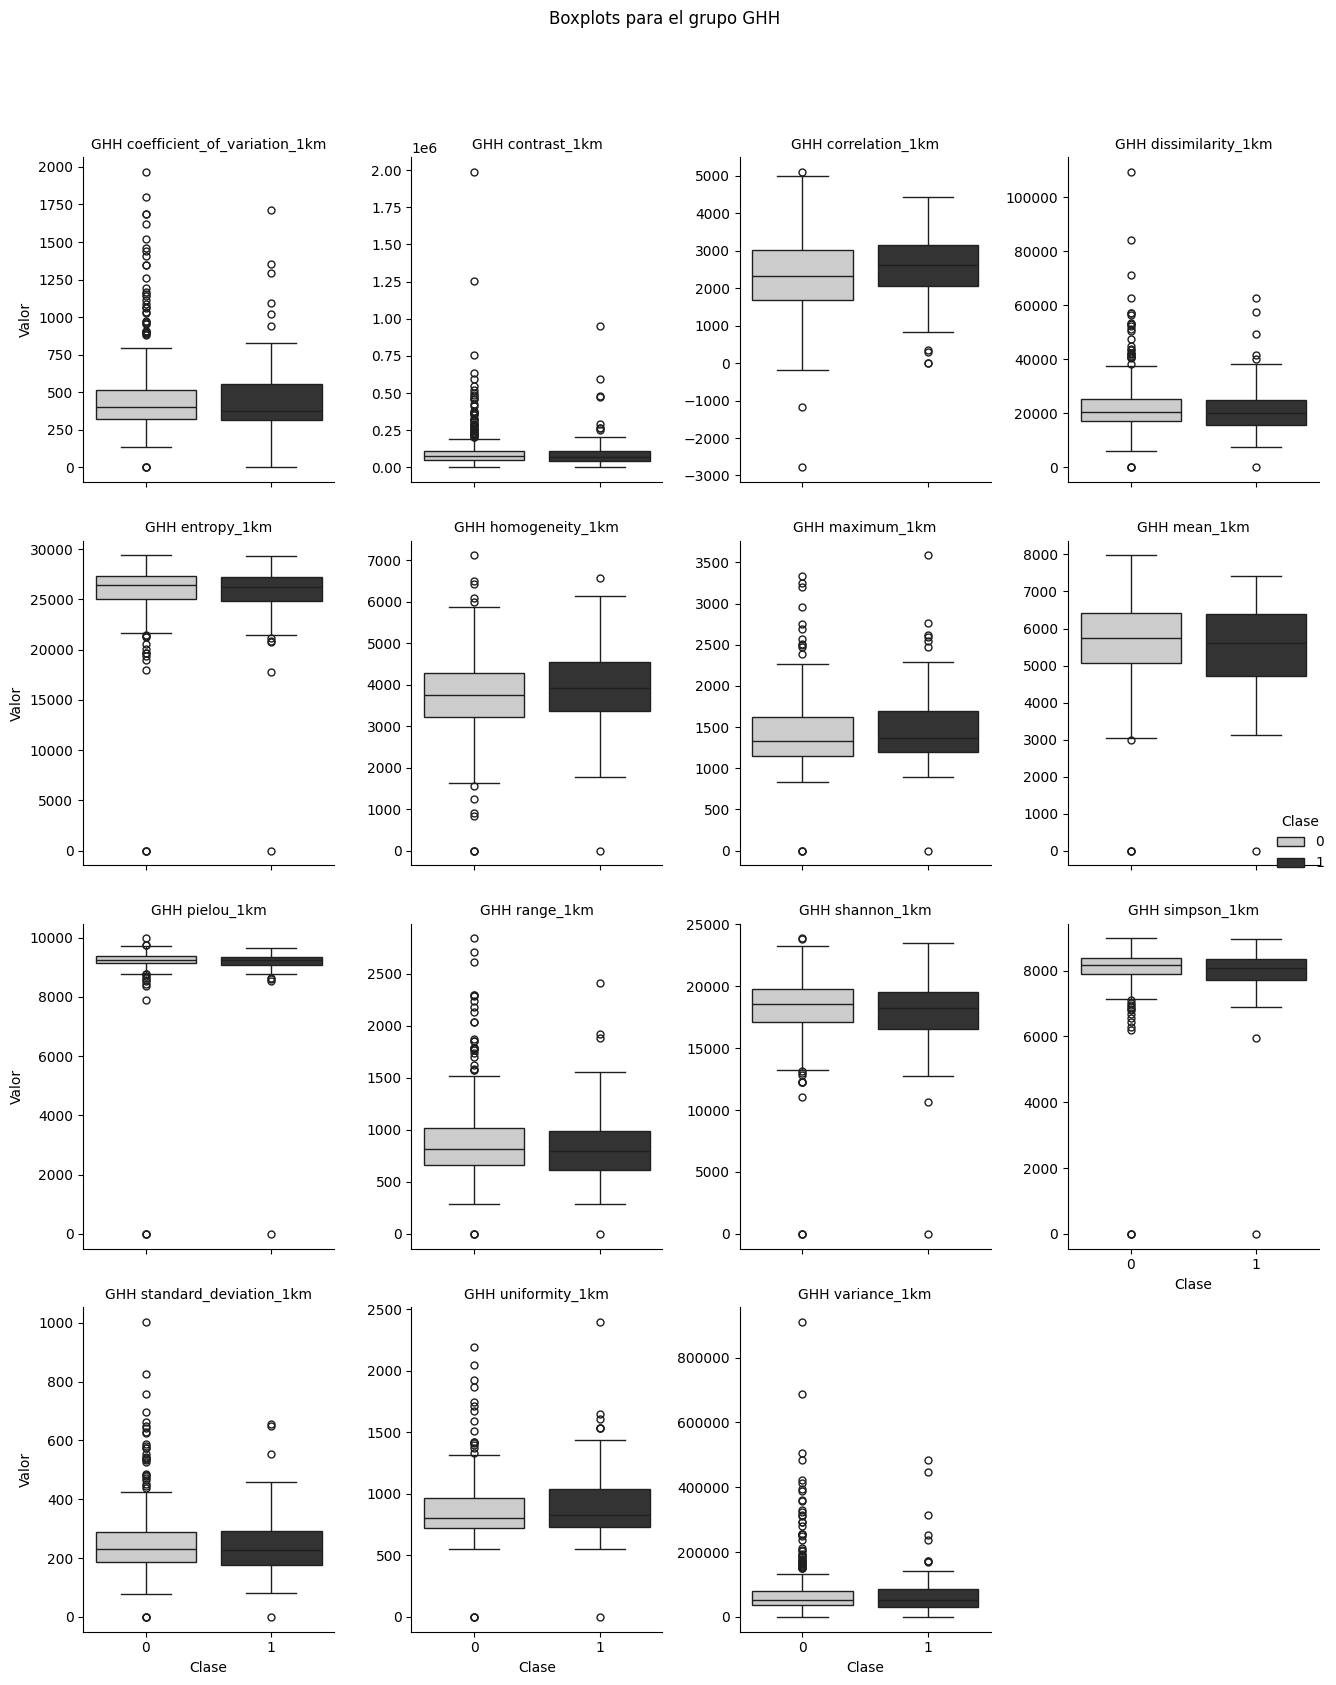

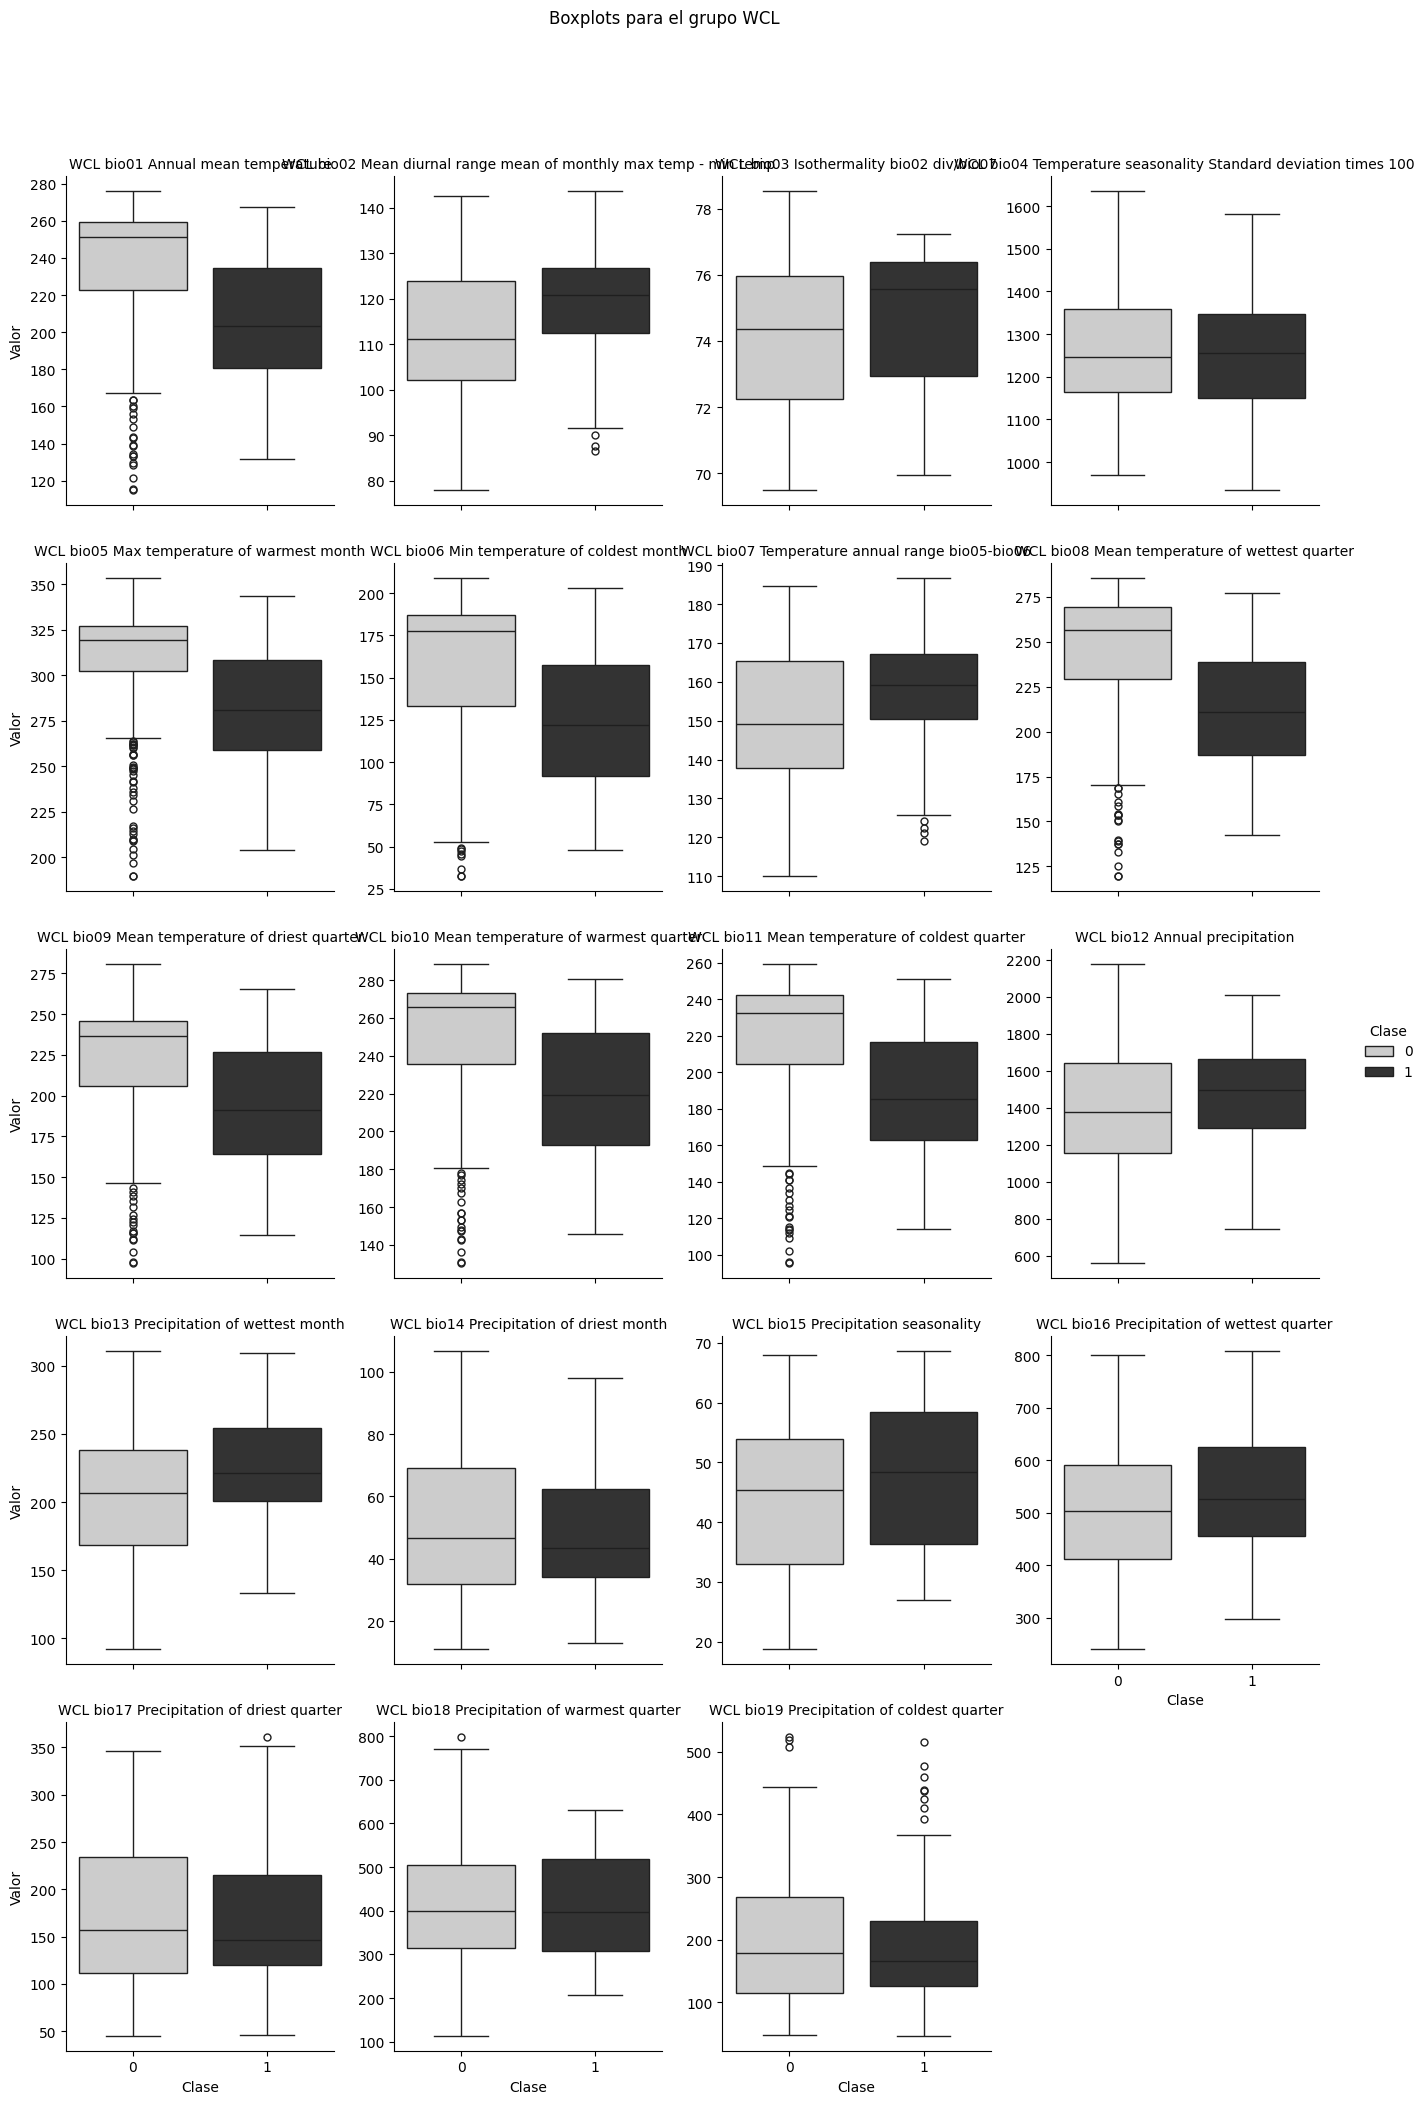

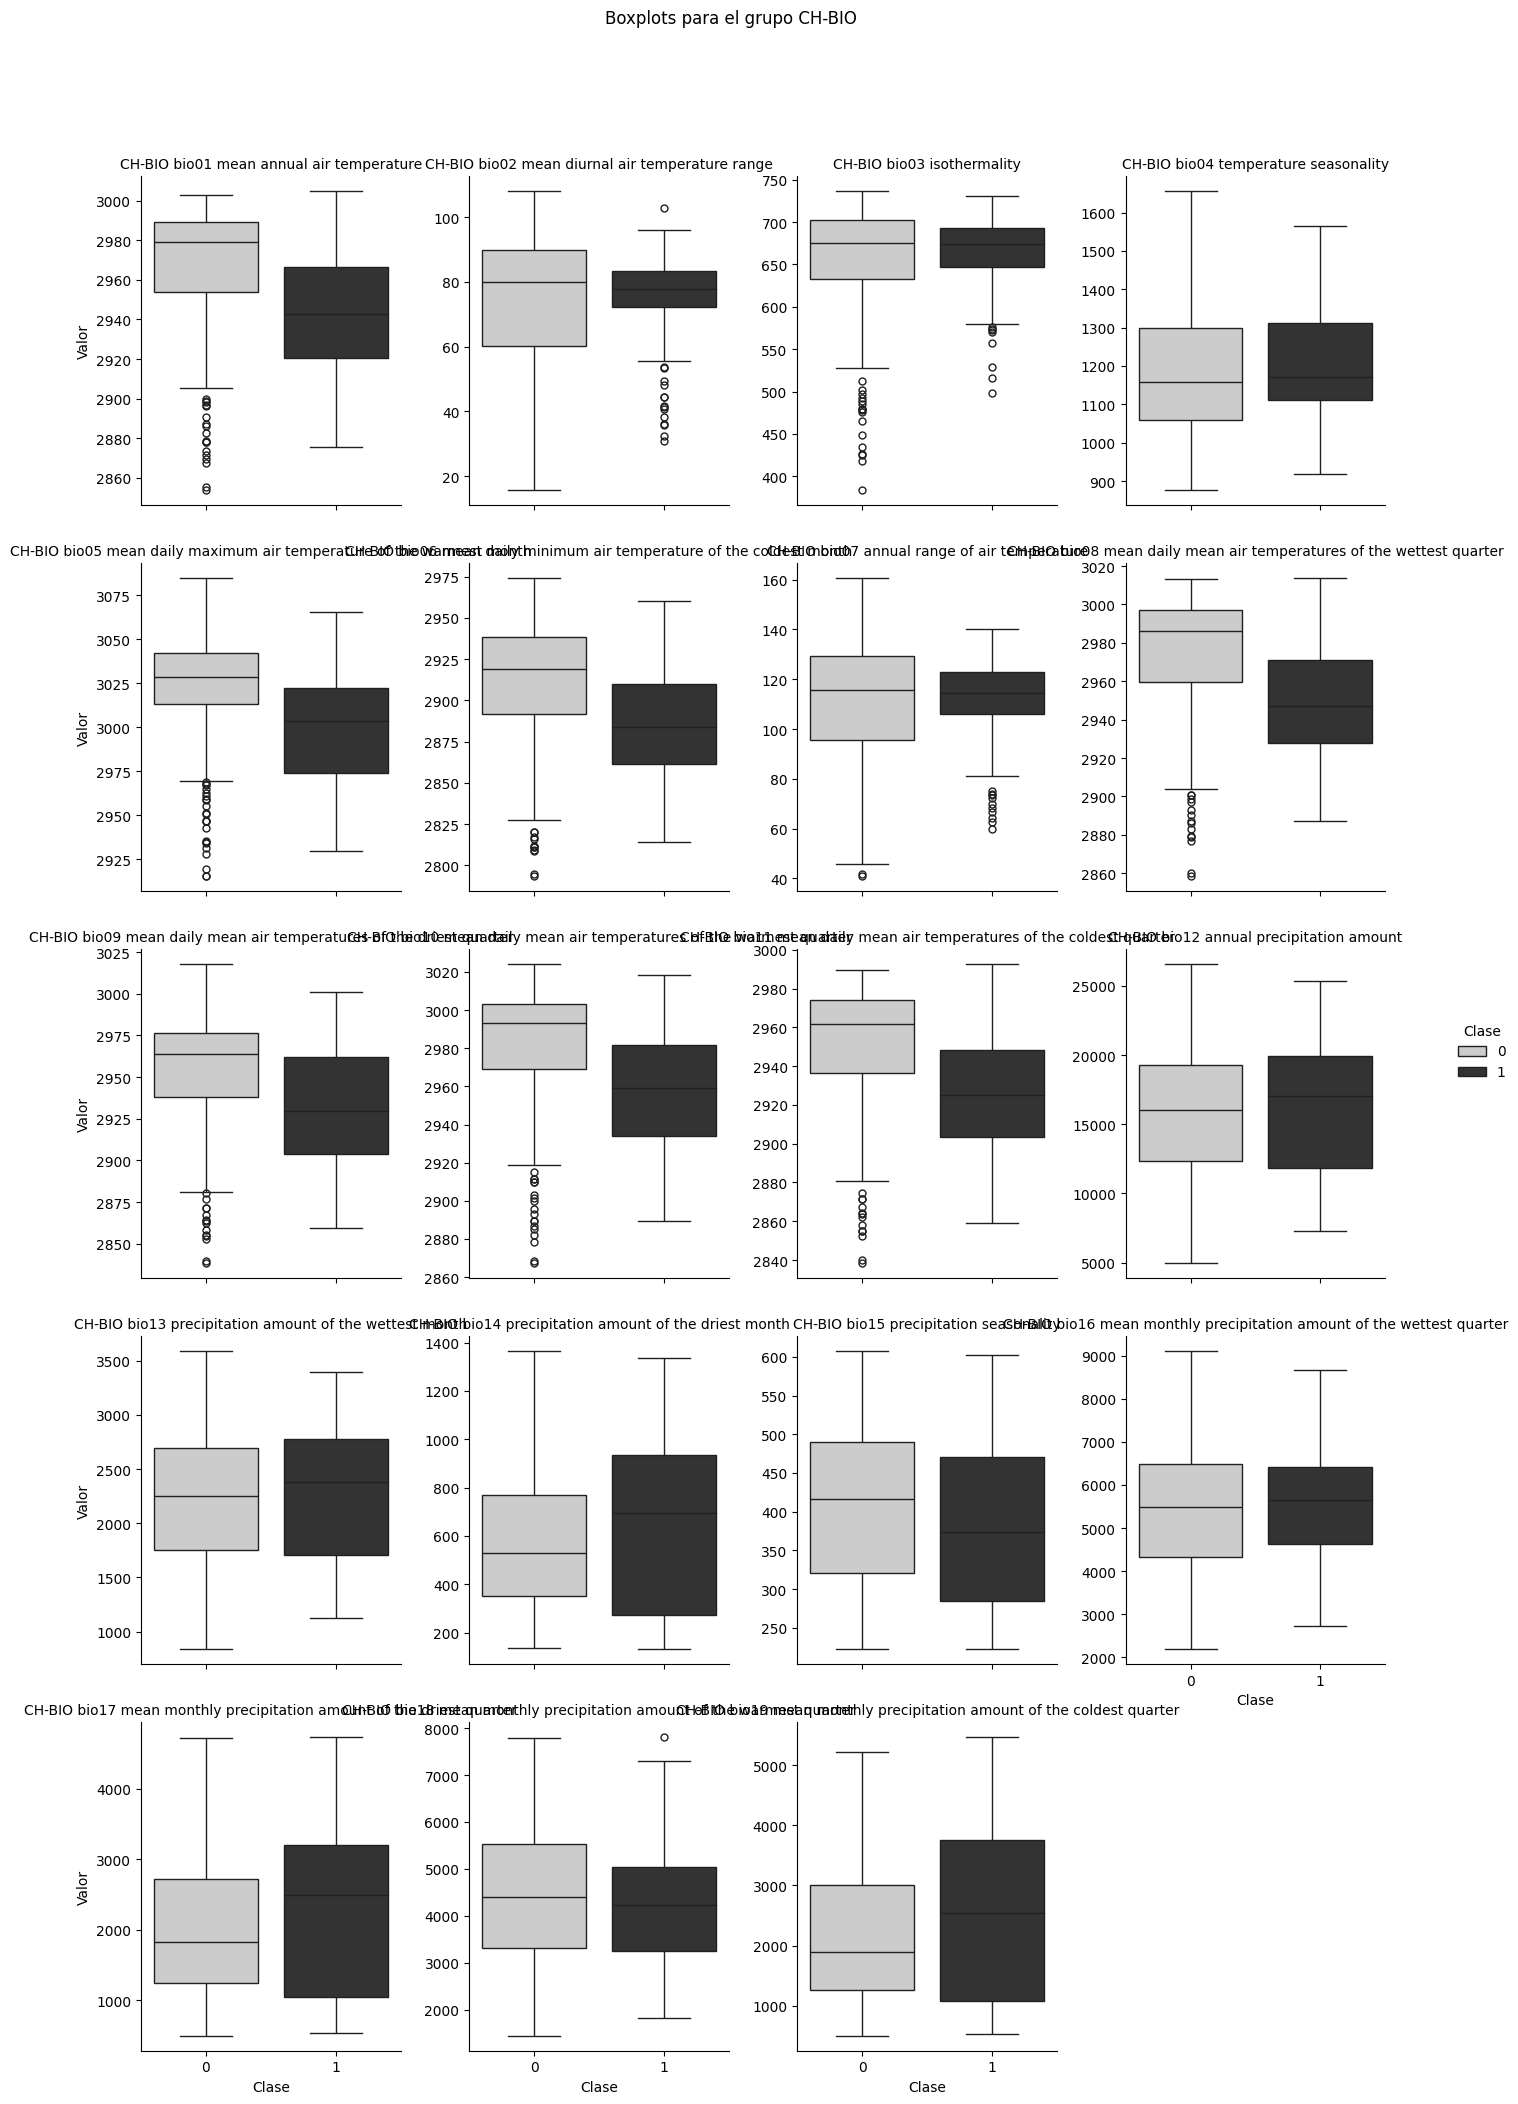

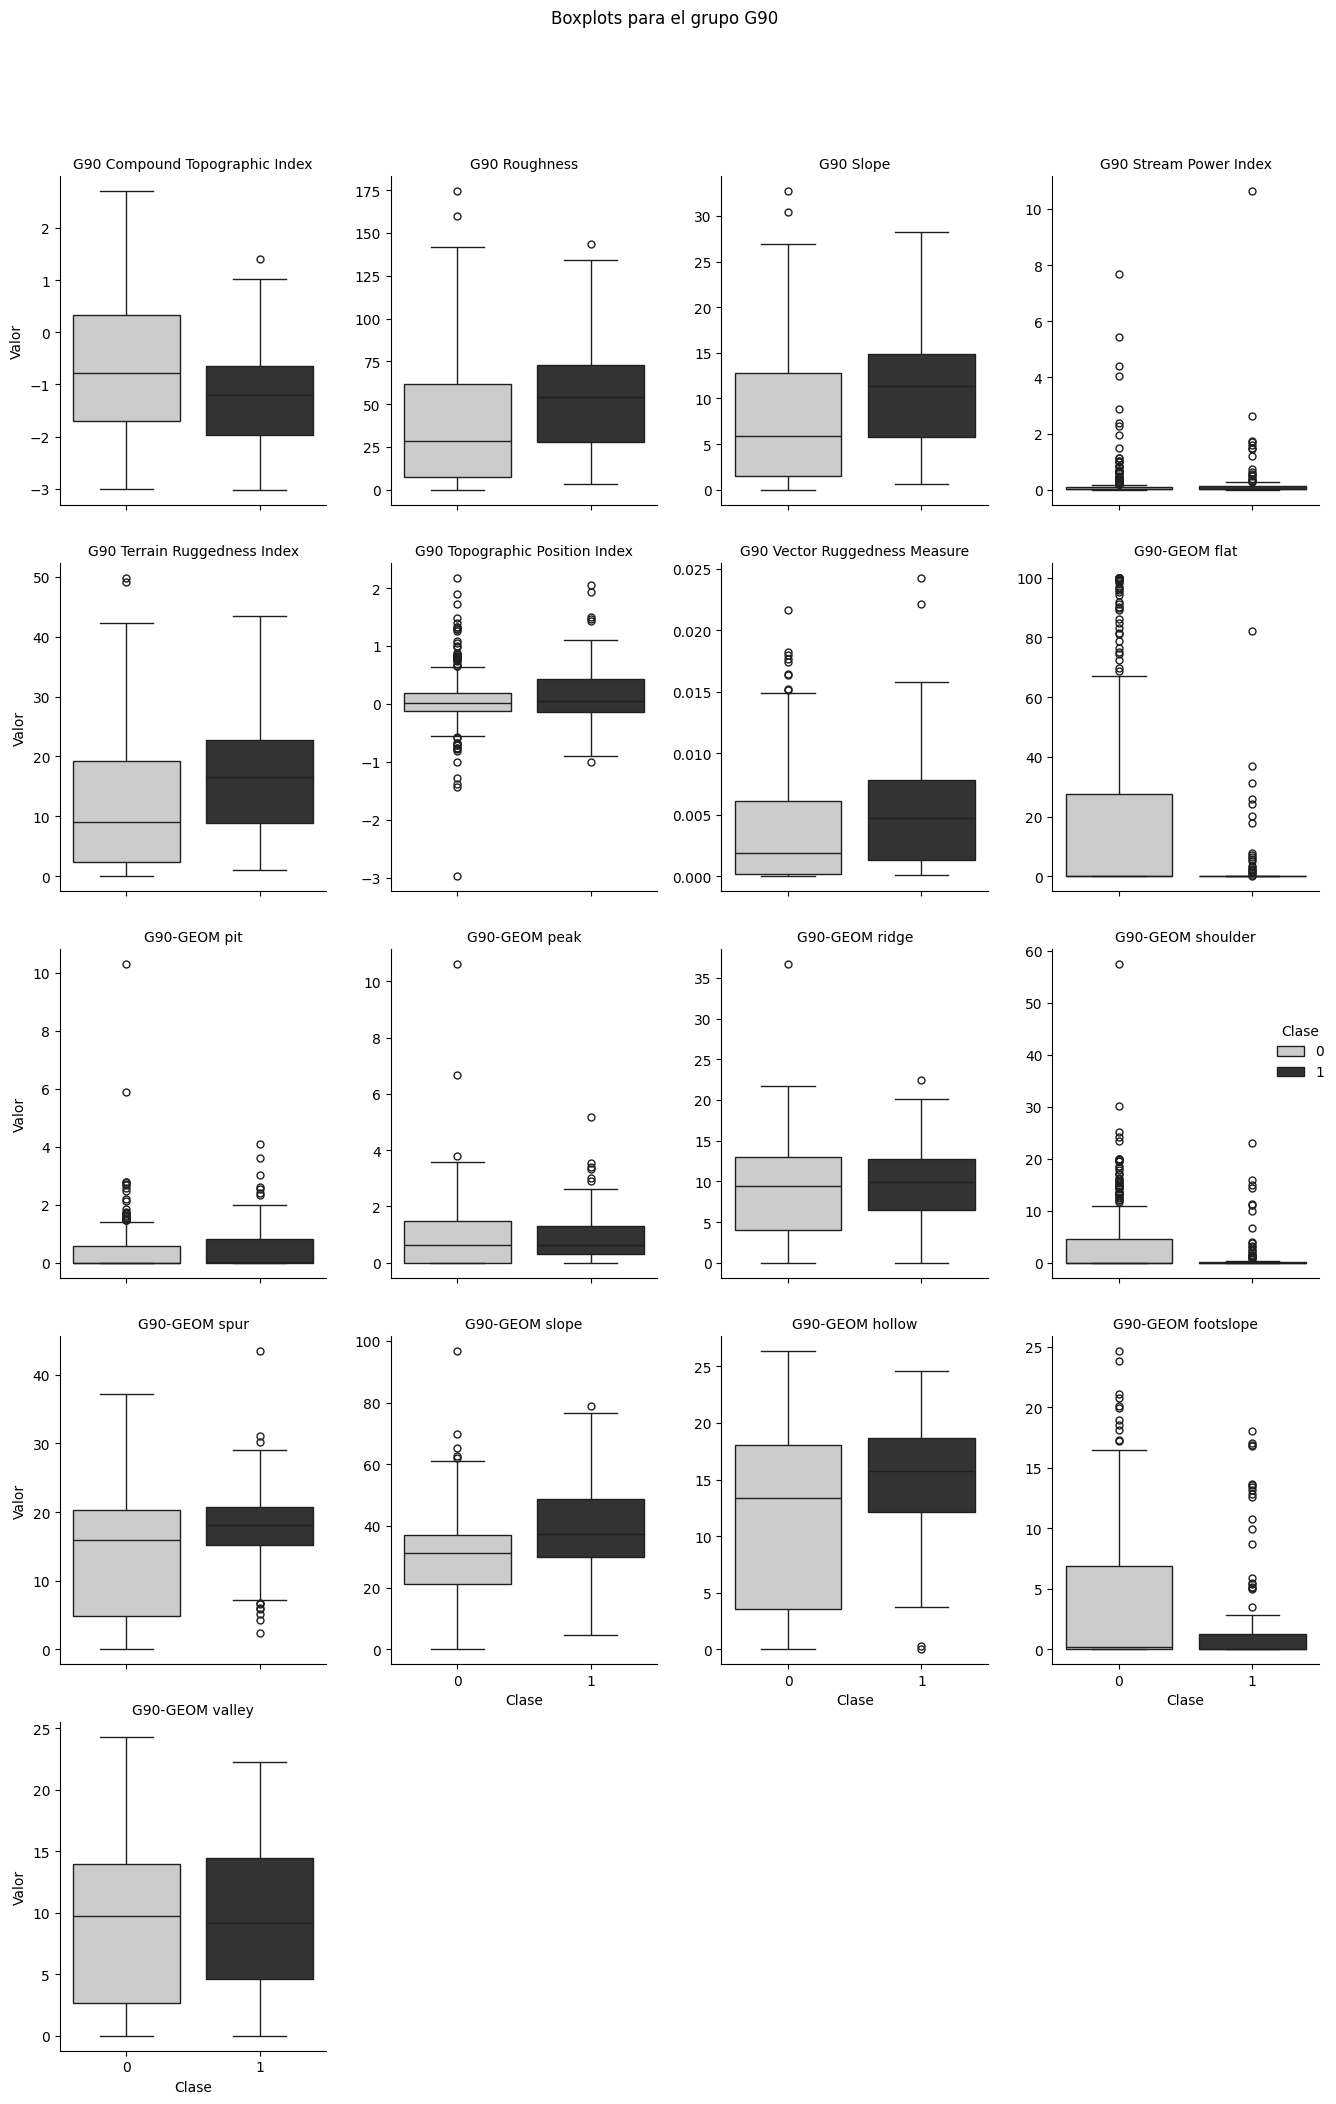

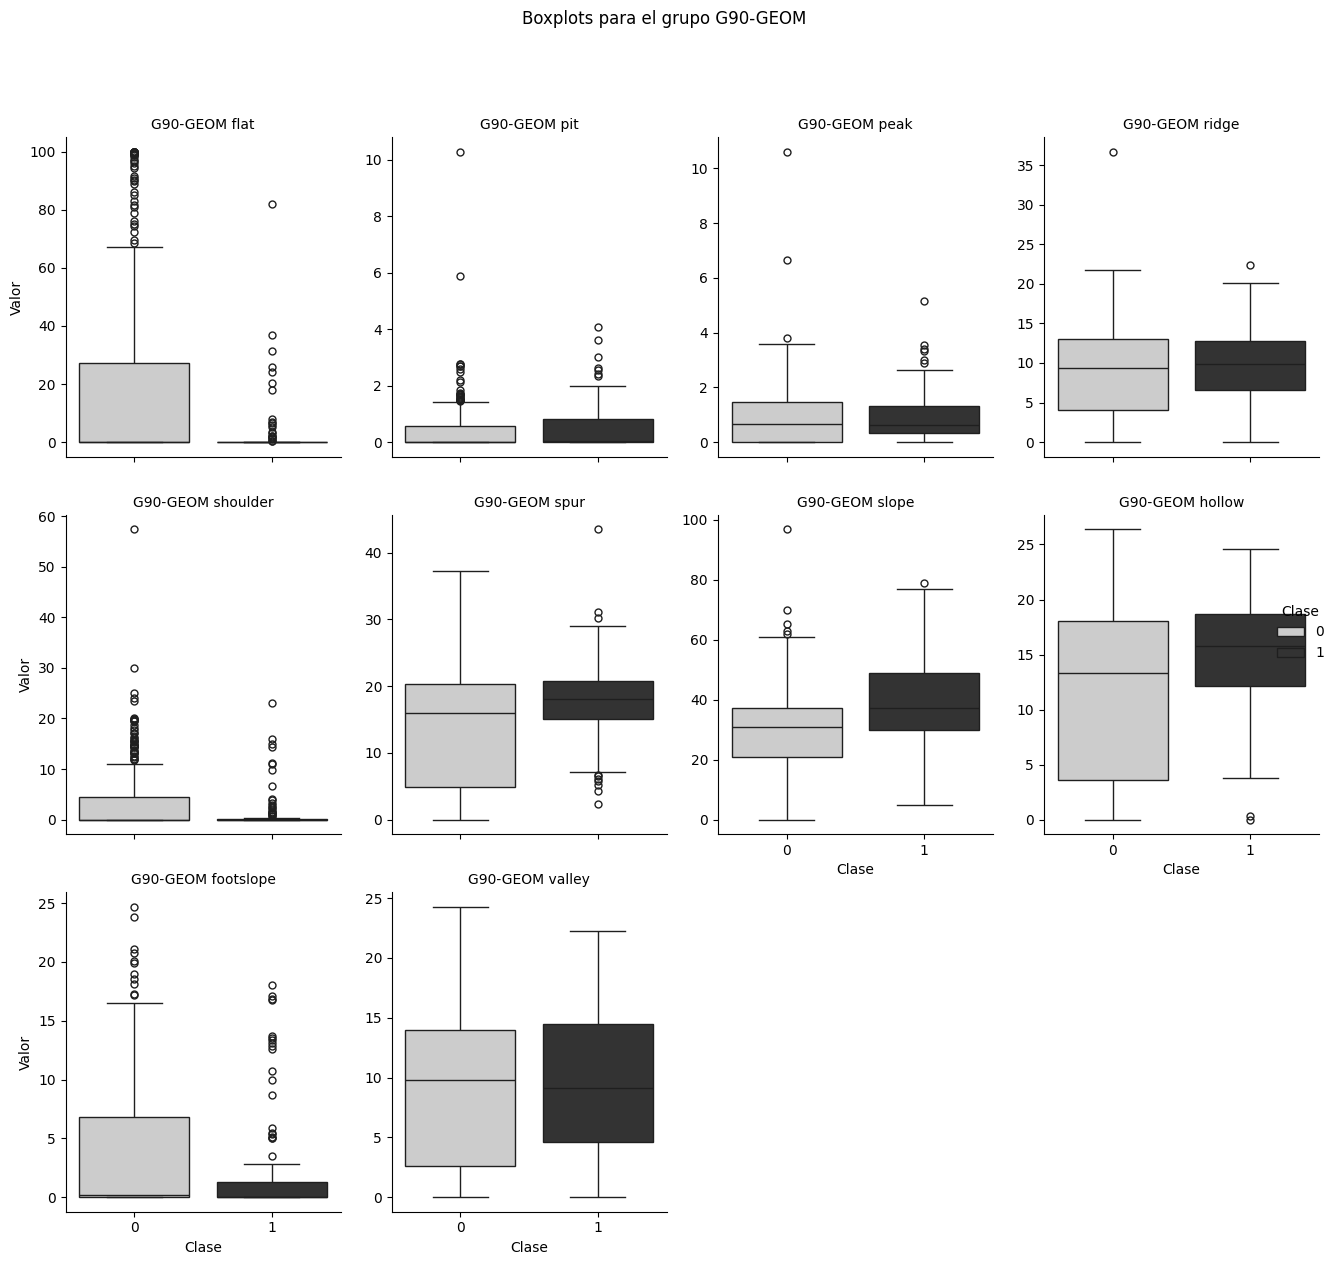

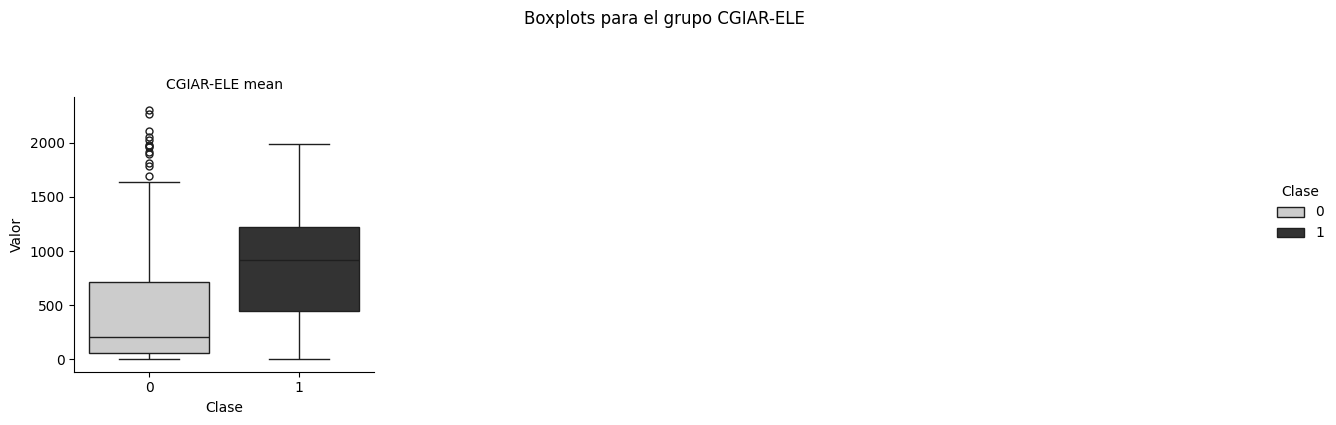

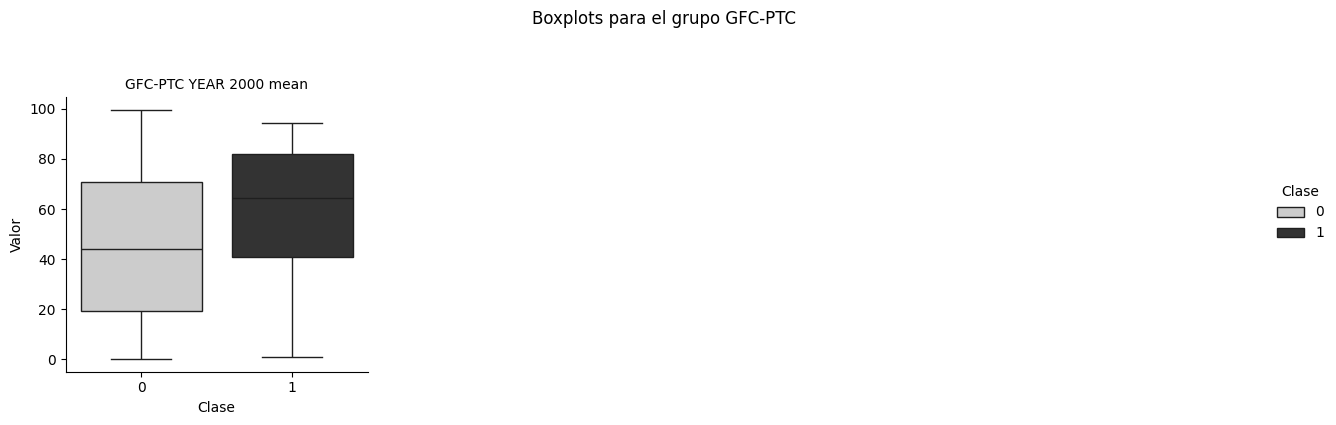

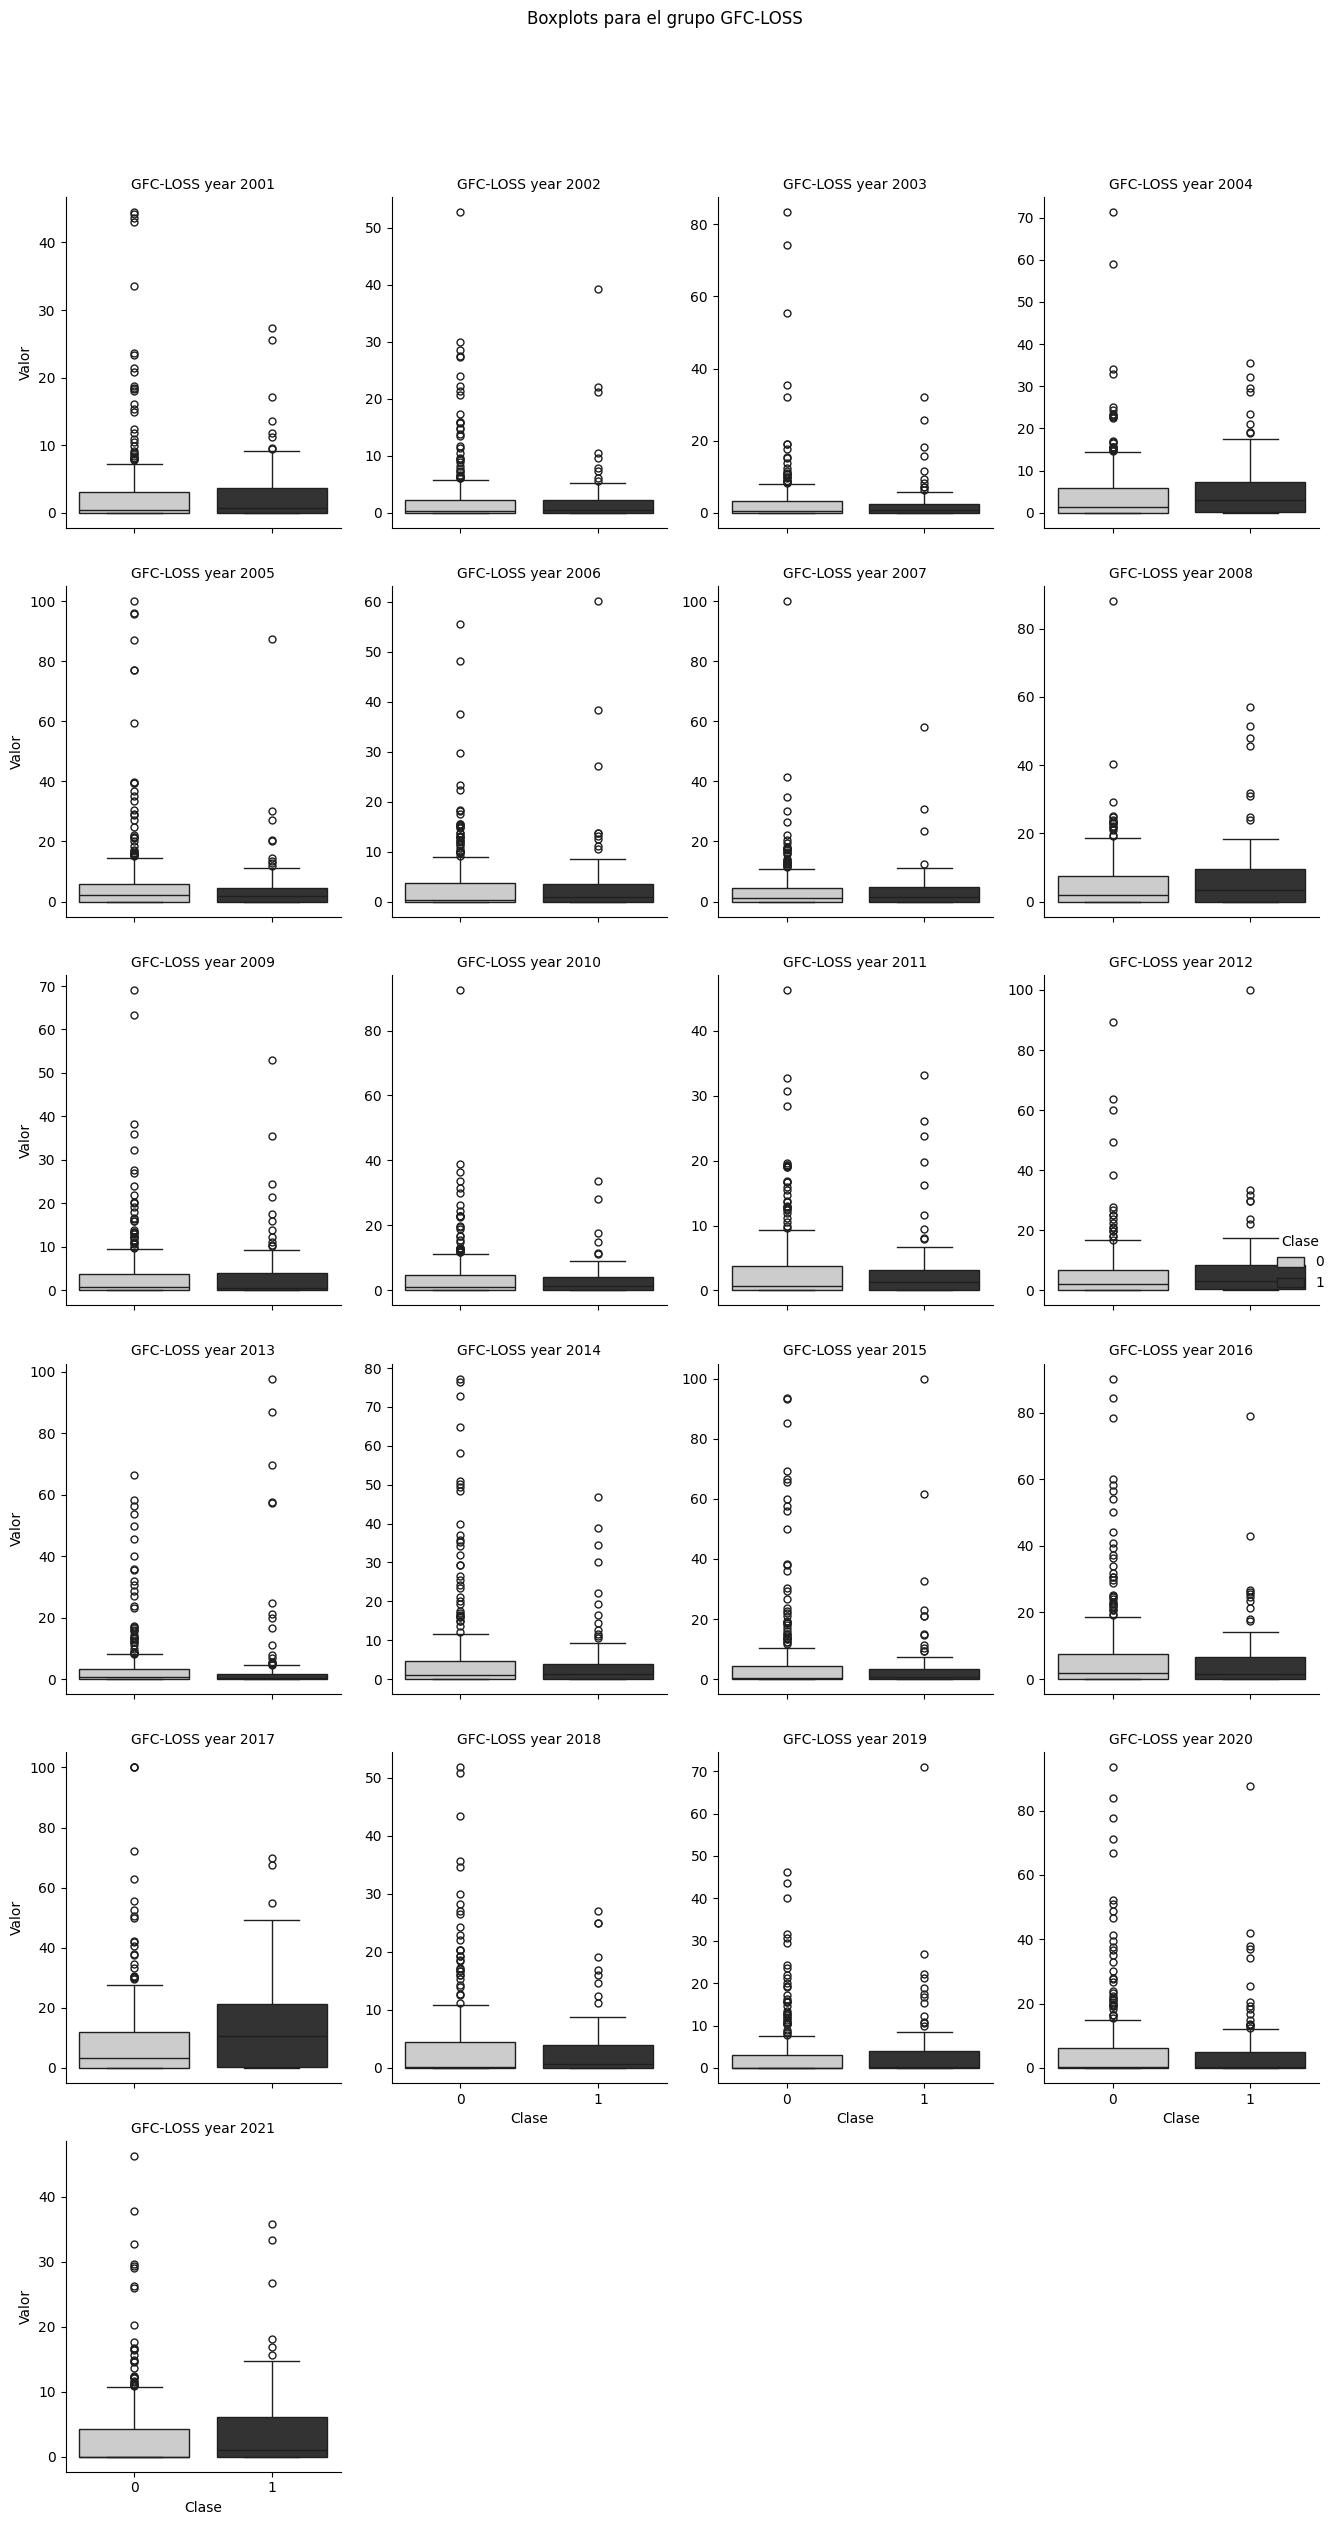

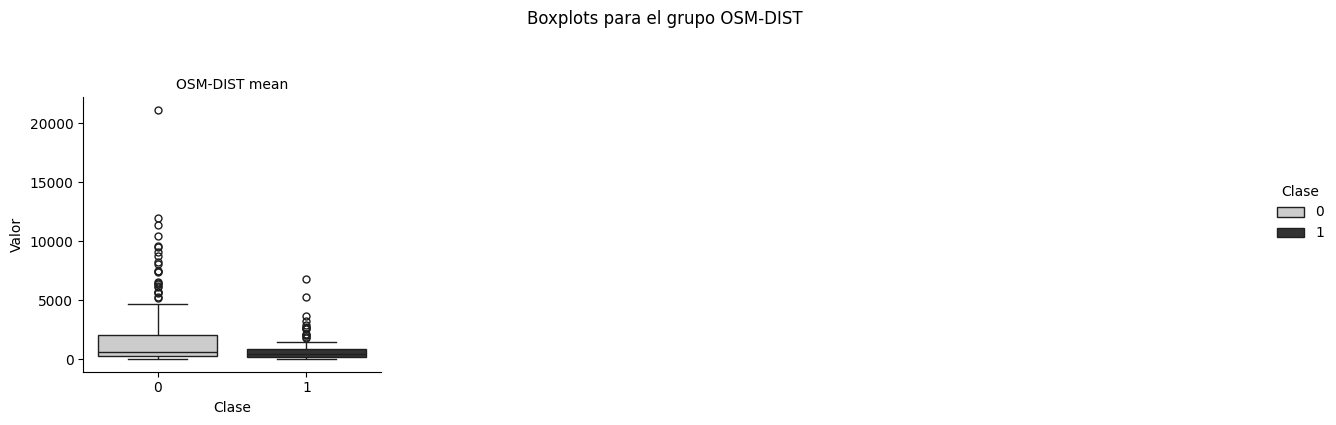

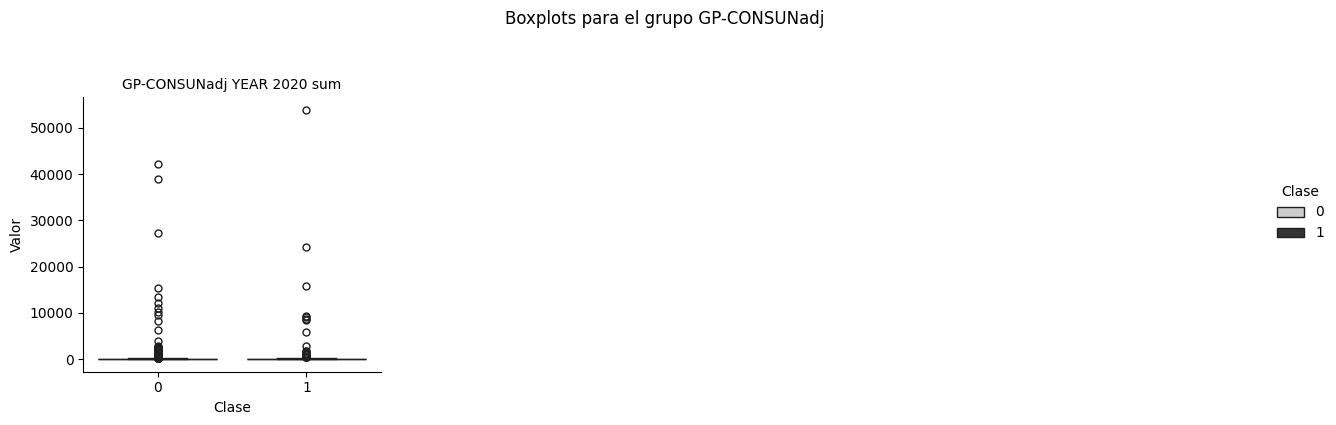

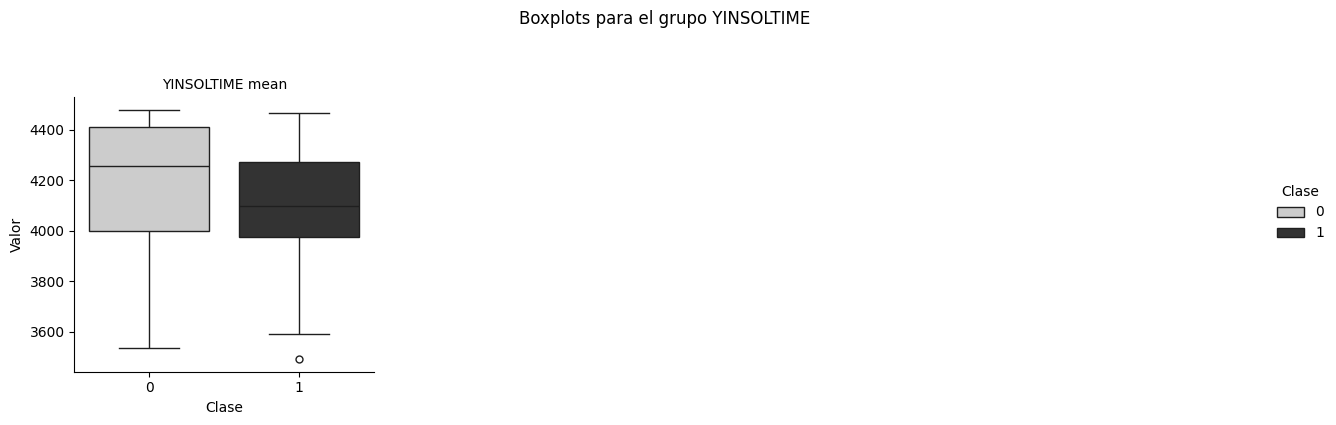

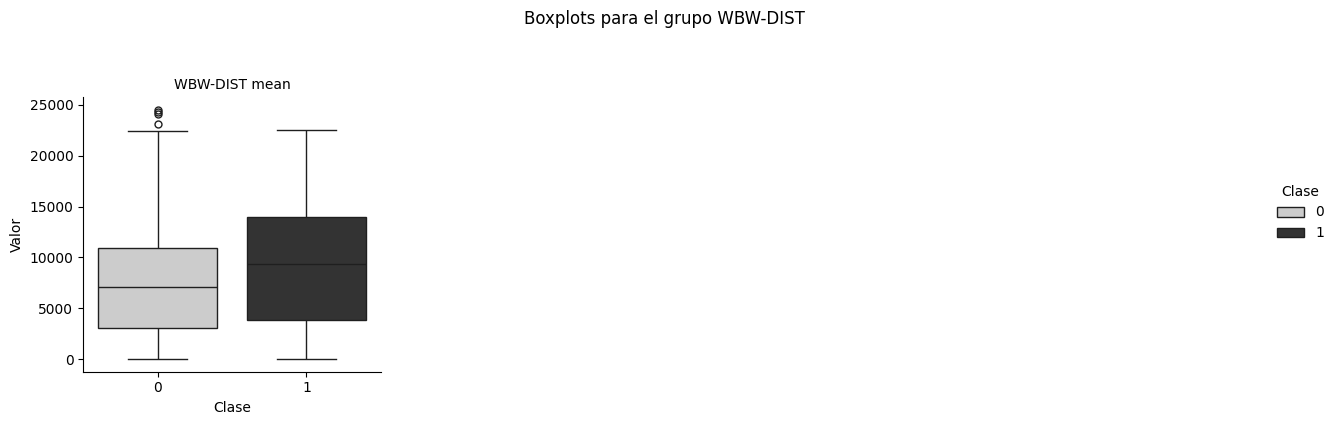

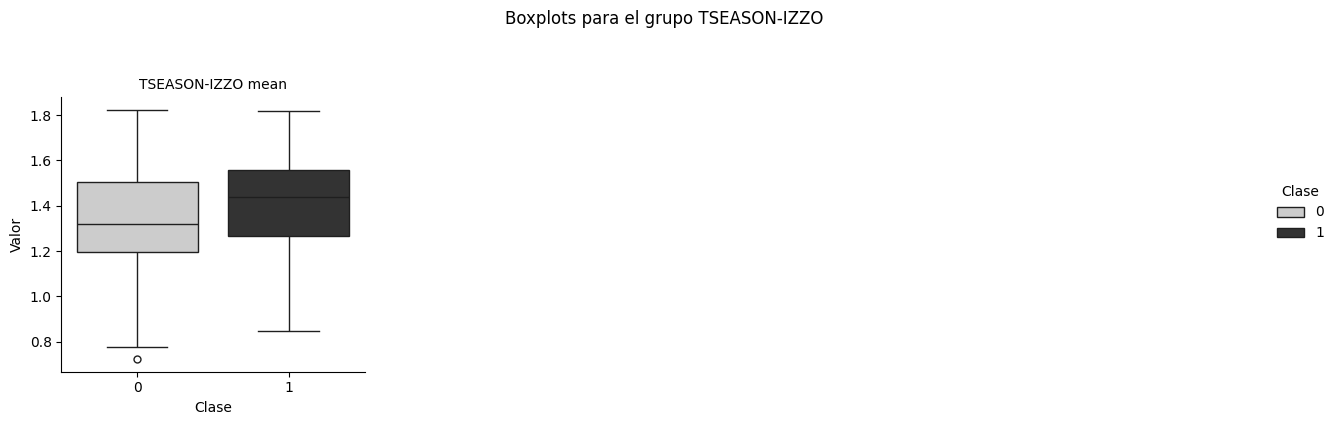

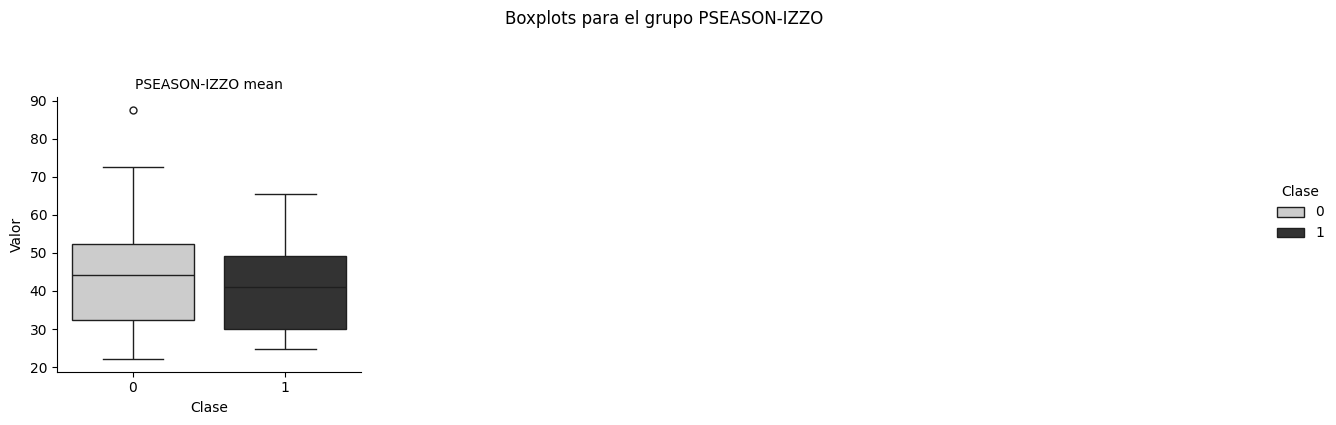

In [66]:

groups = pa_with_features.columns.str.split().str[0].unique() 


palette = {0: "#CCCCCC", 1: "#333333"}


for group in groups:
    
    variables_group = [col for col in pa_with_features.columns if col.startswith(group) and col not in ['CLASS', 'geometry', 'index_right', 'hex_id']]
    
    if variables_group:  
        
        df_long = pd.melt(pa_with_features, id_vars='CLASS', value_vars=variables_group, var_name='variable', value_name='value')


       
        g = sns.catplot(
            data=df_long,
            x="CLASS", y="value",
            hue="CLASS",  
            palette=palette,  
            col="variable", col_wrap=4,  
            kind="box", height=4, aspect=0.8, sharey=False
        )

        
        g.set_titles("{col_name}")
        g.set_axis_labels("Clase", "Valor")  
        g._legend.set_title("Clase")  
        
        plt.suptitle(f"Boxplots para el grupo {group}", y=1.05)  
        plt.tight_layout()
        plt.show()

In [67]:

feature_columns = [col for col in va7.columns if col not in ['geometry', 'hex_id', 'index_right', 'CLASS']]
pa_with_features = pa_with_features.dropna(subset=feature_columns)
train_xs = pa_with_features[feature_columns].values  
train_y = pa_with_features['CLASS'].values  

target_xs = va7[feature_columns].dropna().values  

In [68]:

CLASS_MAP = {
    'rf': RandomForestClassifier(),
    'et': ExtraTreesClassifier(),
    'xgb': XGBClassifier(),
    'lgbm': LGBMClassifier(verbose=-1) 
}


for name, model in CLASS_MAP.items():
    
    k = 5  
    kf = model_selection.KFold(n_splits=k)
    accuracy_scores = model_selection.cross_val_score(model, train_xs, train_y, cv=kf, scoring='accuracy')
    print(f"Clasificador {name}.\nPrecisión de la validación cruzada con {k} particiones: {accuracy_scores.mean() * 100:.2f}% (+/- {accuracy_scores.std() * 200:.2f}%)")

   
    model.fit(train_xs, train_y)
    
   
    va7_pred = va7.dropna().copy()
    
    va7_pred['CLASS_pred_' + name] = model.predict_proba(target_xs)[:, 1] 

    
    output_dir = 'salidas'
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, f"{name}_predictions.gpkg")
    va7_pred[['geometry', 'CLASS_pred_' + name]].to_file(output_file, driver="GPKG")

    print(f"Predicciones de {name} guardadas en {output_file}\n")

Clasificador rf.
Precisión de la validación cruzada con 5 particiones: 68.84% (+/- 70.55%)


INFO:Created 12,990 records


Predicciones de rf guardadas en salidas/rf_predictions.gpkg

Clasificador et.
Precisión de la validación cruzada con 5 particiones: 68.59% (+/- 65.01%)


INFO:Created 12,990 records


Predicciones de et guardadas en salidas/et_predictions.gpkg

Clasificador xgb.
Precisión de la validación cruzada con 5 particiones: 71.06% (+/- 66.14%)


INFO:Created 12,990 records


Predicciones de xgb guardadas en salidas/xgb_predictions.gpkg

Clasificador lgbm.
Precisión de la validación cruzada con 5 particiones: 70.56% (+/- 62.64%)


INFO:Created 12,990 records


Predicciones de lgbm guardadas en salidas/lgbm_predictions.gpkg



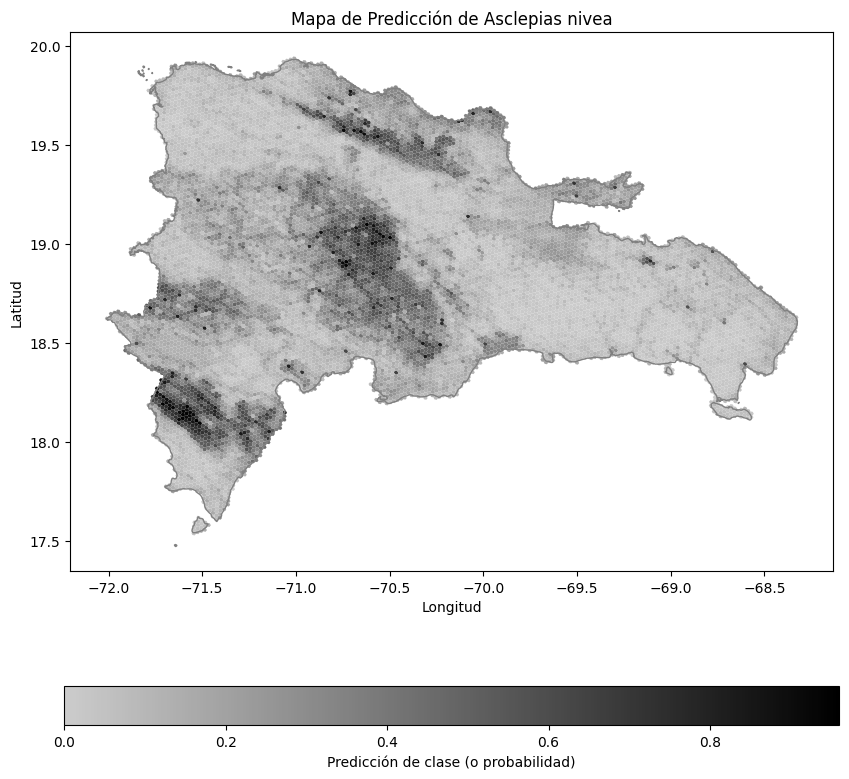

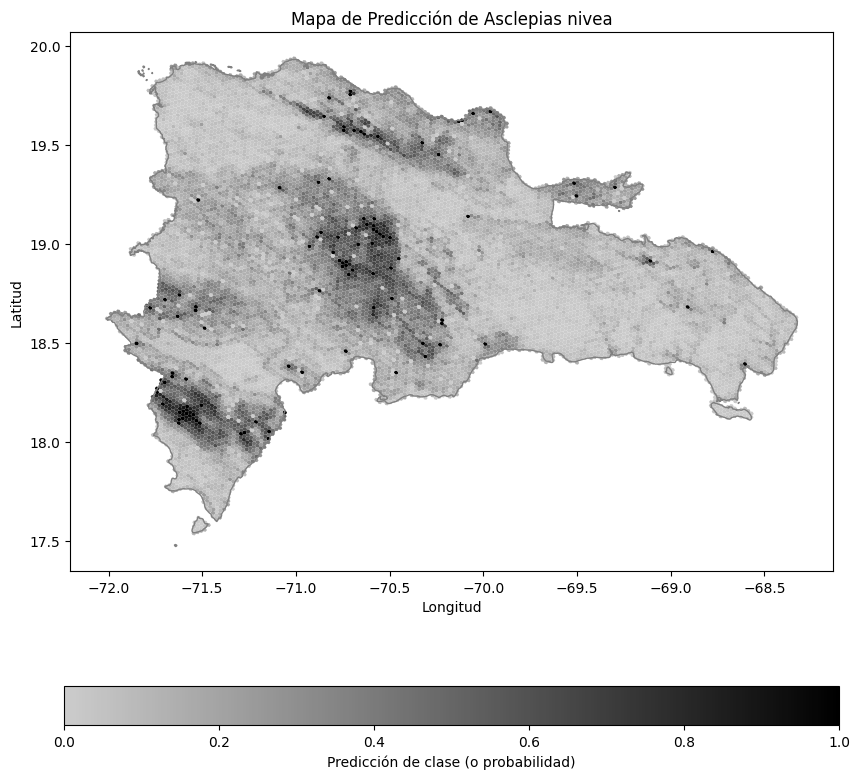

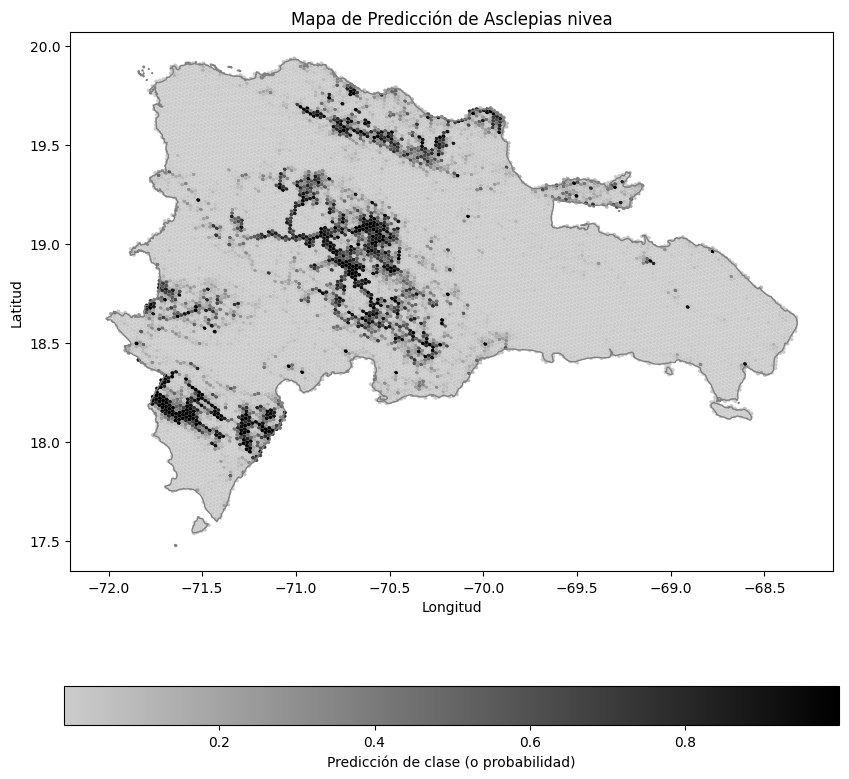

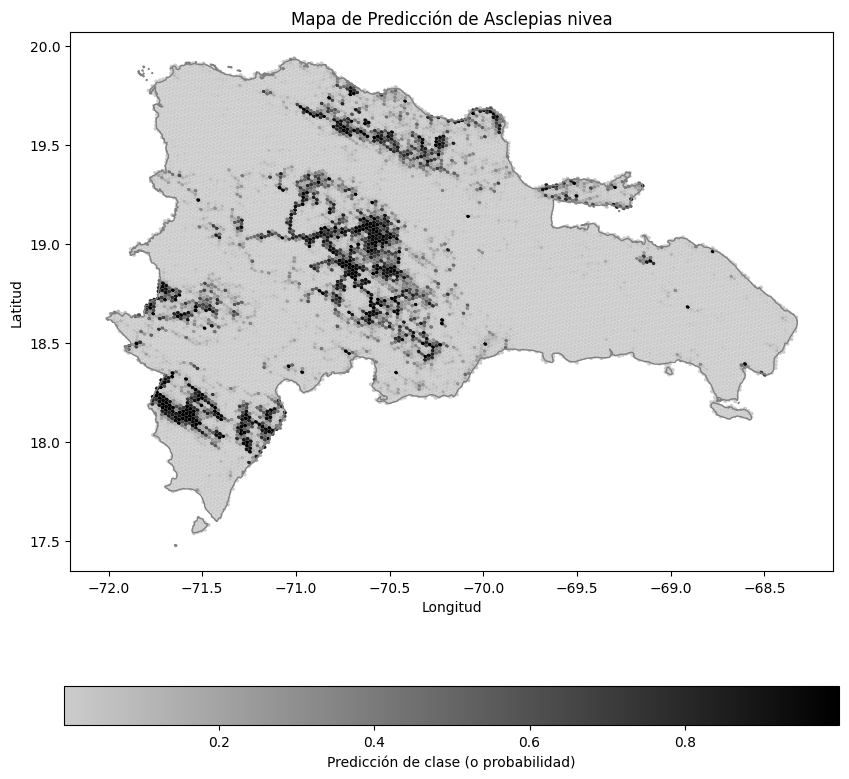

In [37]:

pred_files = sorted(glob.glob("salidas/*_predictions.gpkg"))  
pred_files = [pred_files[i] for i in [2, 0, 3, 1]]


cmap = LinearSegmentedColormap.from_list("gris_a_negro", ["#CCCCCC", "#000000"])


for pred_file in pred_files:
   
    gdf_pred = gpd.read_file(pred_file)
    
   
    model_name = pred_file.split('/')[-1].split('_')[0]
    
    
    fig, ax = plt.subplots(figsize=(10, 10))    
   
    gdf_pred.plot(column=f'CLASS_pred_{model_name}', ax=ax, cmap=cmap, legend=True,
                  legend_kwds={'label': "Predicción de clase (o probabilidad)", 'orientation': "horizontal"})
    
    rd.plot(ax=ax, color='none', edgecolor='grey') 
    
    
    ax.set_title(f"Mapa de Predicción de Asclepias nivea")
    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    
    
    plt.show()